In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from IPython import display
plt.style.use('seaborn')
sns.set()

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp

def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_ftir_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer2/spectrum_depths'][:]
        return depths

def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps

def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def get_visible_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer1/spectrum_depths'][:]
        return depths   

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]
        return insertions

def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions

def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp

def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp

def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

def normalize_depth(depth, depth_min, depth_max):
    return (depth - depth_min) / (depth_max - depth_min)

def get_spectrometer_name(file, session, spectrometer_number):
    with h5py.File(file, 'r') as h5_file:
        name = h5_file[session].attrs[f'spectrometer{spectrometer_number}'][:]
        return name

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
insertions_list_df = pd.read_csv('data/insertions_210616.csv')
insertions_list_df

filename     date  unique     session calibration  \
0  210616_testing/testing_210616.h5  6/16/21       1  session001      cal004   
1  210616_testing/testing_210616.h5  6/16/21       2  session001      cal004   
2  210616_testing/testing_210616.h5  6/16/21       3  session002      cal002   
3  210616_testing/testing_210616.h5  6/16/21       4  session002      cal002   
4  210616_testing/testing_210616.h5  6/16/21       5  session003      cal001   
5  210616_testing/testing_210616.h5  6/16/21       6  session003      cal001   
6  210616_testing/testing_210616.h5  6/16/21       7  session004      cal001   
7  210616_testing/testing_210616.h5  6/16/21       8  session004      cal001   

  insertion spectrometer1 spectrometer2     comments  waittime  
0    ins001       visspec        nirone   (1,1), red         1  
1    ins002       visspec        nirone   (1,1), red         1  
2    ins001       visspec        nirone   (1,3), red         1  
3    ins002       visspec        nirone   (1,3), red         2  
4    ins001    ftirengine        nirone  (1,3), blue         2  
5    ins002    ftirengine        nirone  (1,3), blue         1  
6    ins001    ftirengine       visspec          NaN         2  
7    ins002    ftirengine       visspec          NaN         1

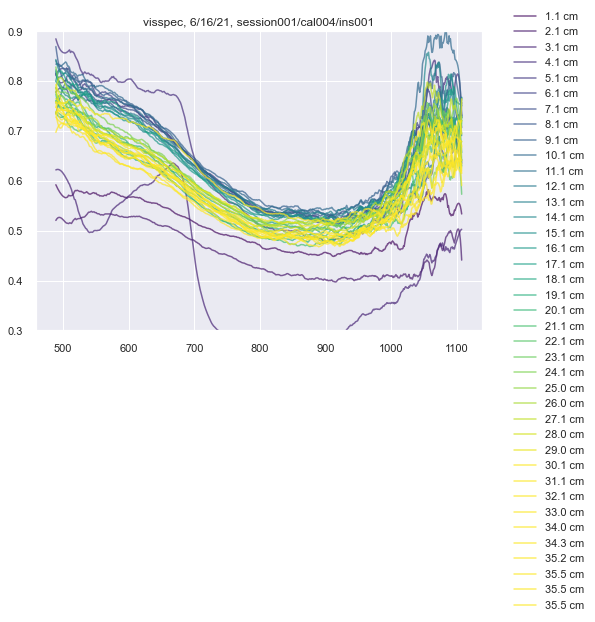

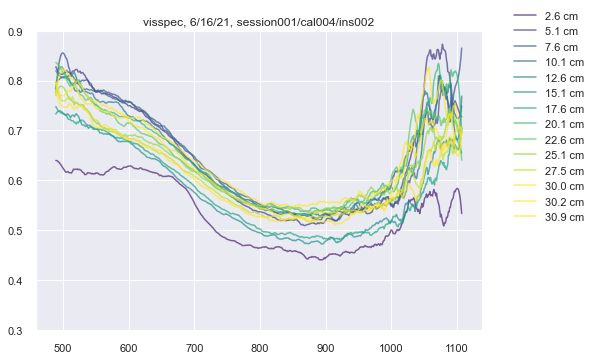

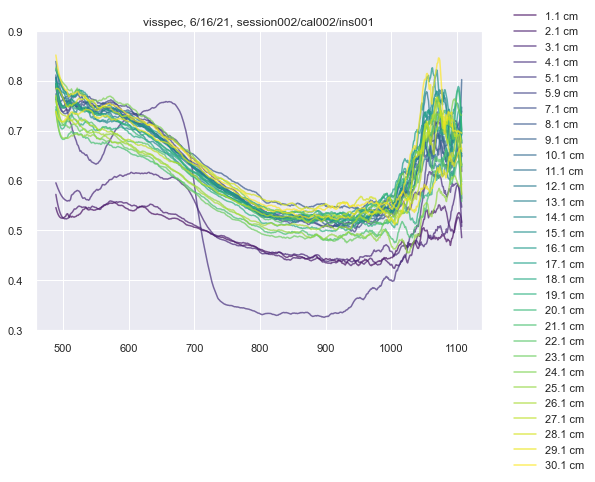

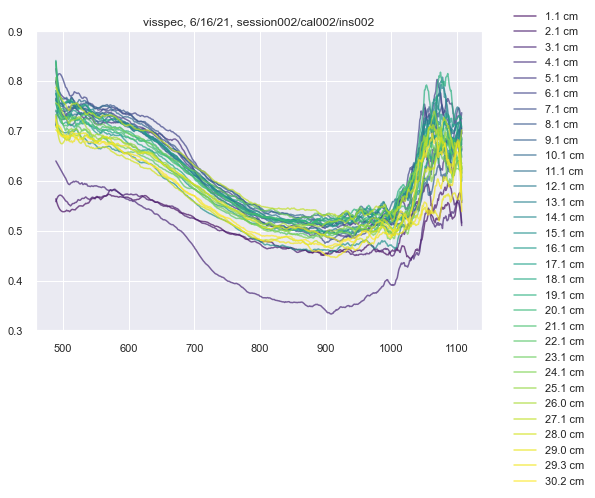

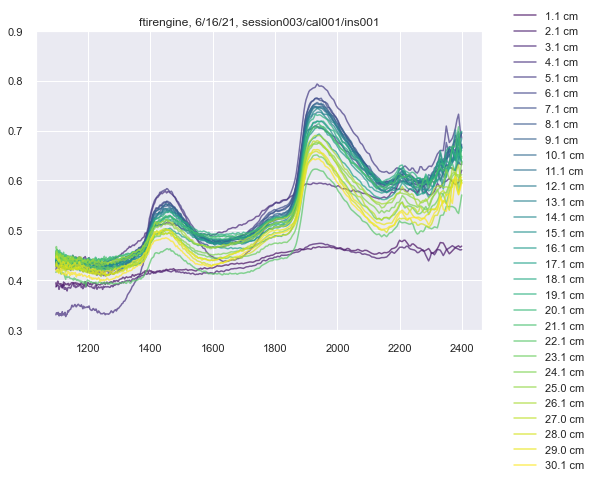

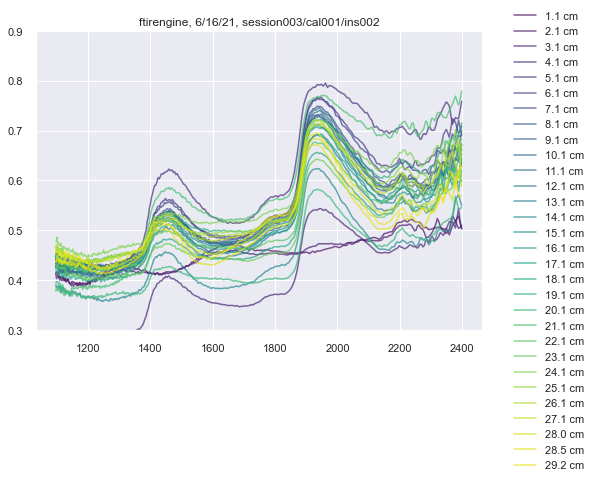

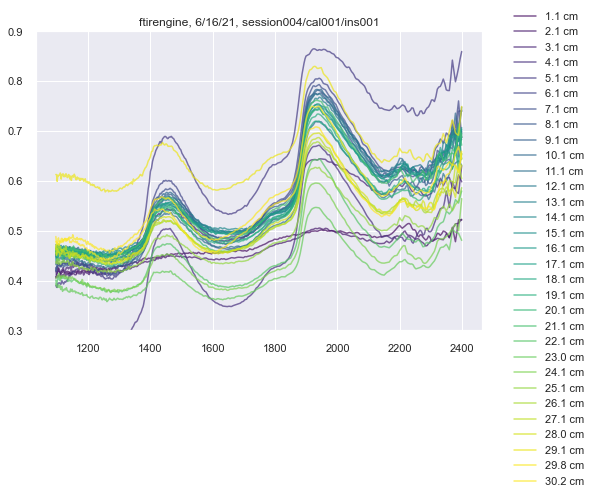

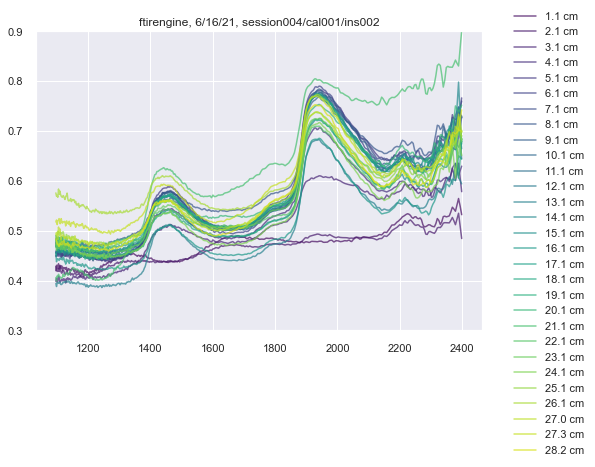

In [4]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name
ftir_min_index = 100
ftir_max_index = 665

for index in insertions_list_df.index.values:
    session = insertions_list_df['session'][index]
    calibration = insertions_list_df['calibration'][index]
    insertion = insertions_list_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    insertion_path = f'{session}/{calibration}/{insertion}'
    
    waves = get_visible_wavelength_vector(file, cal_path)
    absorbances = get_visible_insertion_absorbances(file, insertion_path)
    depths = get_visible_insertion_spectrum_depths(file, insertion_path)
    depth_min = 0.0
    depth_max = 30.0
    name = get_spectrometer_name(file, session, 1)
    
    if name == 'ftirengine':
        absorbances = absorbances[:, ftir_min_index:ftir_max_index]
        waves = waves[ftir_min_index:ftir_max_index]
    
    fig, ax = plt.subplots()
    ax.set_title(f"{name}, 6/16/21, {insertion_path}")
    ax.set_ylim(0.3, 0.9)
    for i in range(absorbances.shape[0]):
        color = plt.cm.viridis(normalize_depth(depths[i], depth_min, depth_max))
        if name == 'visspec':
            ax.plot(waves, savgol_filter(absorbances[i, :], 21, 3), 
                    color=color, alpha=0.7, label=f'{depths[i]:0.1f} cm')
        else:
            ax.plot(waves, absorbances[i, :], 
                    color=color, alpha=0.7, label=f'{depths[i]:0.1f} cm')
    plt.legend(bbox_to_anchor=(1.05, 0.9, 0.3, 0.2), loc='upper left')
    plt.show()
    plt.close()
        
        
    

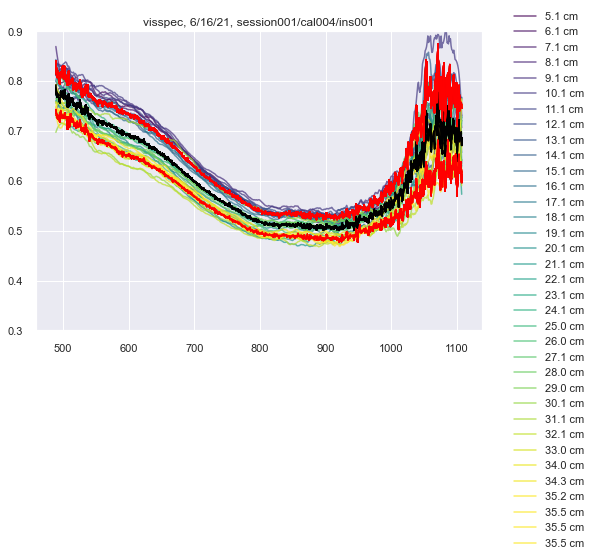

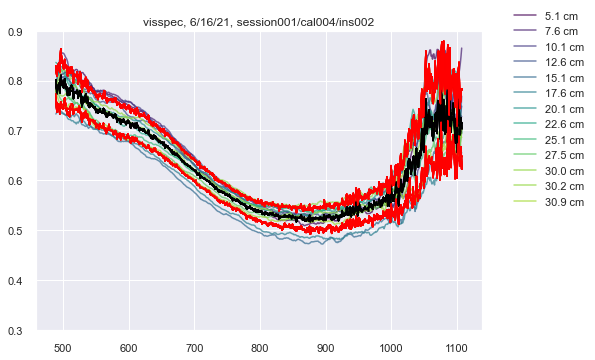

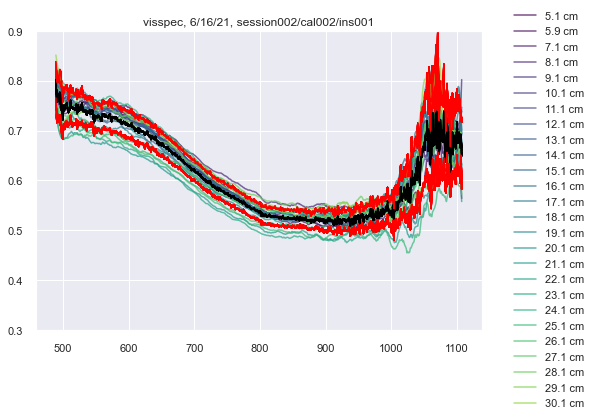

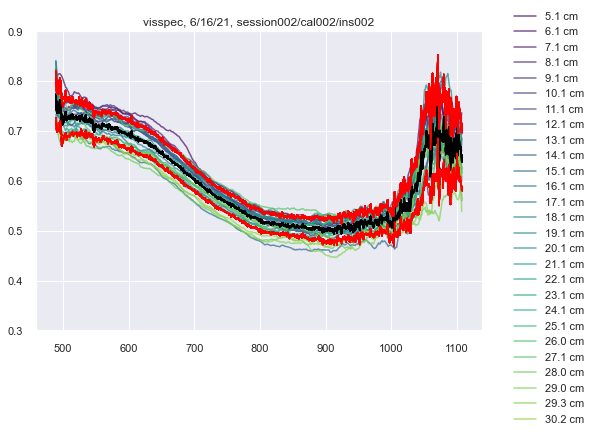

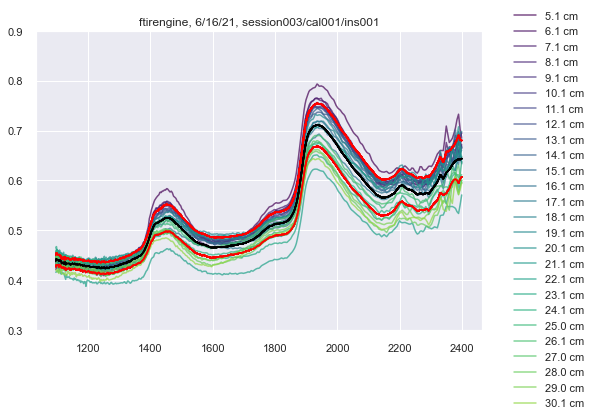

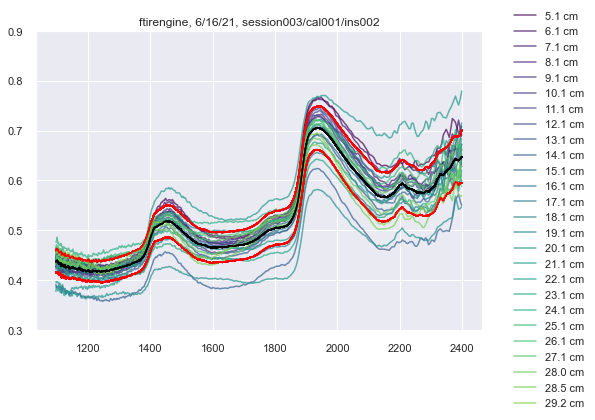

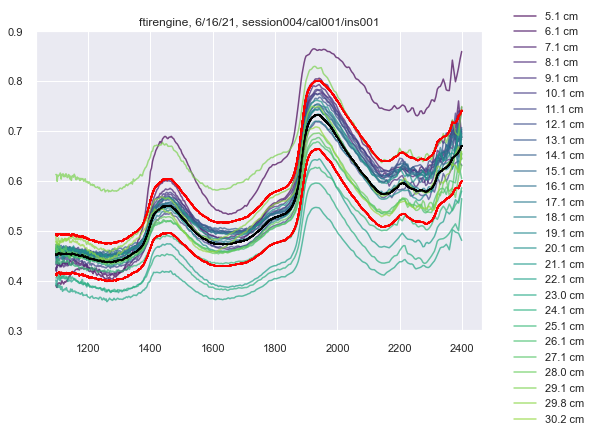

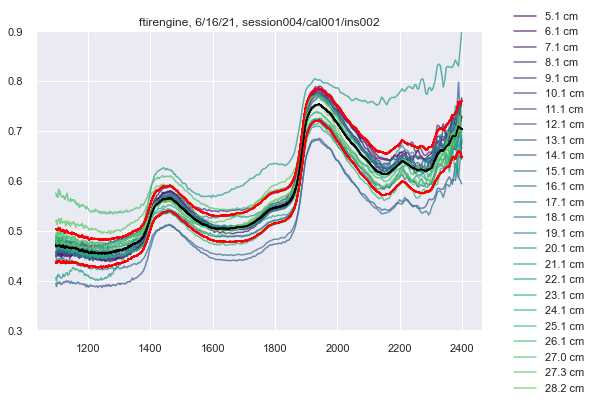

In [5]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name
ftir_min_index = 100
ftir_max_index = 665
depth_min = 5.0
depth_max = 35.0

for index in insertions_list_df.index.values:
    session = insertions_list_df['session'][index]
    calibration = insertions_list_df['calibration'][index]
    insertion = insertions_list_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    insertion_path = f'{session}/{calibration}/{insertion}'
    
    waves = get_visible_wavelength_vector(file, cal_path)
    
    depths = get_visible_insertion_spectrum_depths(file, insertion_path)
    depths_good = depths[depths > 5.0]
    
    absorbances = get_visible_insertion_absorbances(file, insertion_path)
    absorbances_good = absorbances[depths > 5.0]
    
    
    name = get_spectrometer_name(file, session, 1)
    
    if name == 'ftirengine':
        absorbances_good = absorbances_good[:, ftir_min_index:ftir_max_index]
        waves = waves[ftir_min_index:ftir_max_index]
        
    absorbance_mean = np.mean(absorbances_good, axis=0)
    absorbance_sd = np.std(absorbances_good, axis=0)
    absorbance_plus_sd = absorbance_mean + absorbance_sd
    absorbance_minus_sd = absorbance_mean - absorbance_sd
    
    fig, ax = plt.subplots()
    ax.set_title(f"{name}, 6/16/21, {insertion_path}")
    ax.set_ylim(0.3, 0.9)
    for i in range(absorbances_good.shape[0]):
        color = plt.cm.viridis(normalize_depth(depths_good[i], depth_min, depth_max))
        if name == 'visspec':
            ax.plot(waves, savgol_filter(absorbances_good[i, :], 21, 3), 
                    color=color, alpha=0.7, label=f'{depths_good[i]:0.1f} cm')
            ax.plot(waves, savgol_filter(absorbance_mean, 21, 3), color='black')
            ax.plot(waves, savgol_filter(absorbance_plus_sd, 21, 3), color='red')
            ax.plot(waves, savgol_filter(absorbance_minus_sd, 21, 3), color='red')
        else:
            ax.plot(waves, absorbances_good[i, :], 
                    color=color, alpha=0.7, label=f'{depths_good[i]:0.1f} cm')
        ax.plot(waves, absorbance_mean, color='black')
        ax.plot(waves, absorbance_plus_sd, color='red')
        ax.plot(waves, absorbance_minus_sd, color='red')
    plt.legend(bbox_to_anchor=(1.05, 0.9, 0.3, 0.2), loc='upper left')
    plt.show()
    plt.close()

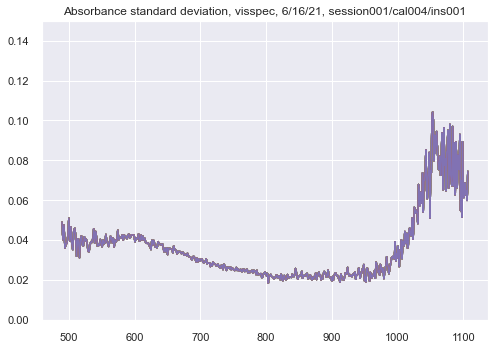

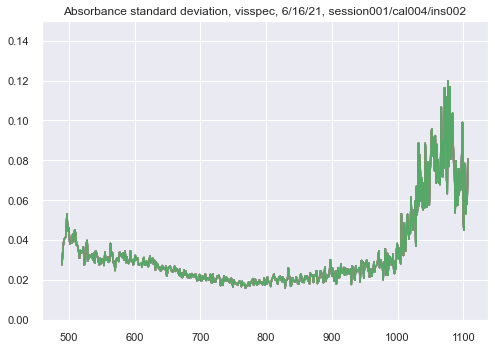

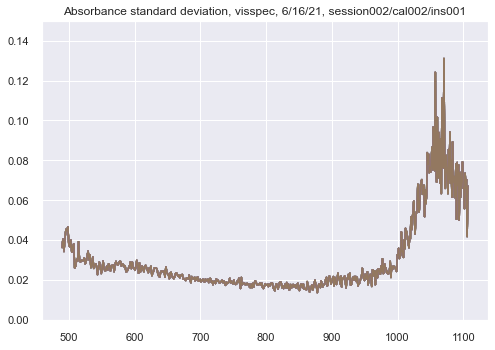

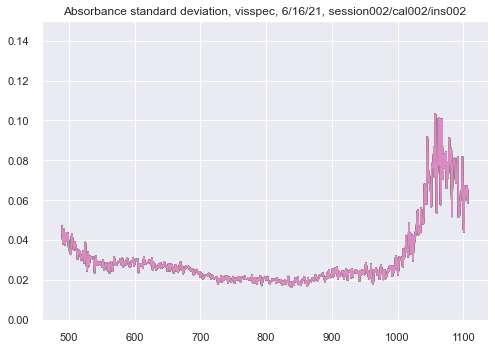

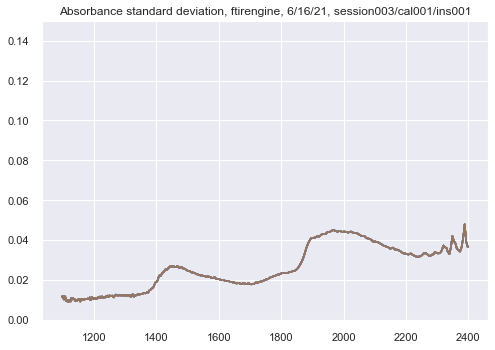

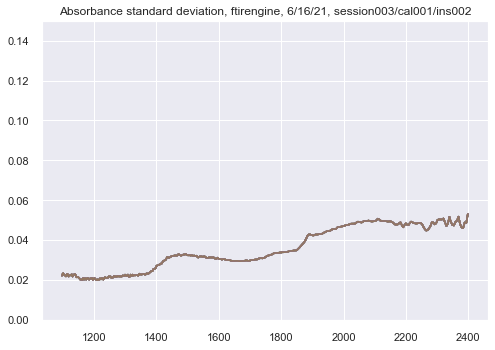

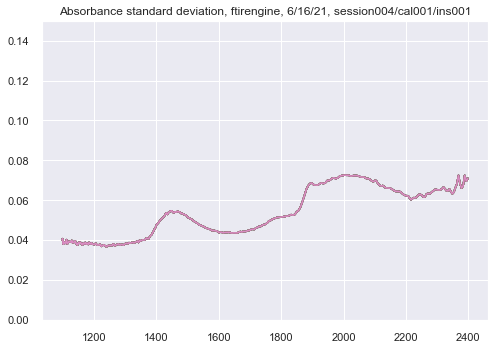

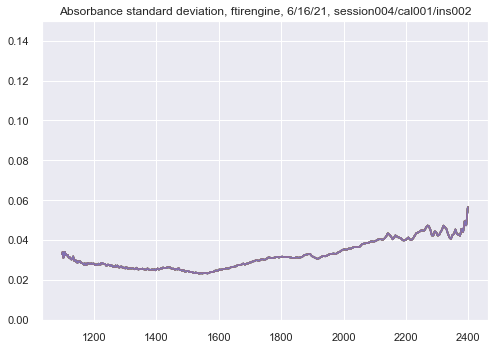

In [6]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name
ftir_min_index = 100
ftir_max_index = 665
depth_min = 5.0
depth_max = 35.0

for index in insertions_list_df.index.values:
    session = insertions_list_df['session'][index]
    calibration = insertions_list_df['calibration'][index]
    insertion = insertions_list_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    insertion_path = f'{session}/{calibration}/{insertion}'
    
    waves = get_visible_wavelength_vector(file, cal_path)
    
    depths = get_visible_insertion_spectrum_depths(file, insertion_path)
    depths_good = depths[depths > 5.0]
    
    absorbances = get_visible_insertion_absorbances(file, insertion_path)
    absorbances_good = absorbances[depths > 5.0]
    
    
    name = get_spectrometer_name(file, session, 1)
    
    if name == 'ftirengine':
        absorbances_good = absorbances_good[:, ftir_min_index:ftir_max_index]
        waves = waves[ftir_min_index:ftir_max_index]
        
    absorbance_mean = np.mean(absorbances_good, axis=0)
    absorbance_sd = np.std(absorbances_good, axis=0)
    absorbance_plus_sd = absorbance_mean + absorbance_sd
    absorbance_minus_sd = absorbance_mean - absorbance_sd
    
    fig, ax = plt.subplots()
    ax.set_title(f"Absorbance standard deviation, {name}, 6/16/21, {insertion_path}")
    ax.set_ylim(0, 0.15)
    for i in range(absorbances_good.shape[0]):
        
        ax.plot(waves, absorbance_sd)
    
    plt.show()
    plt.close()

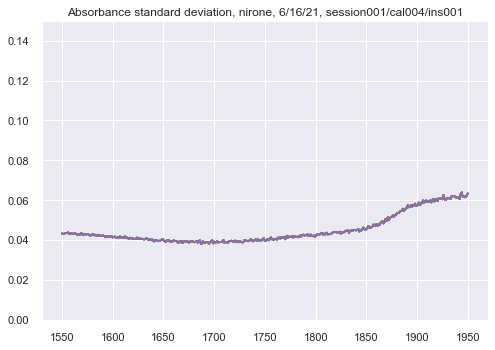

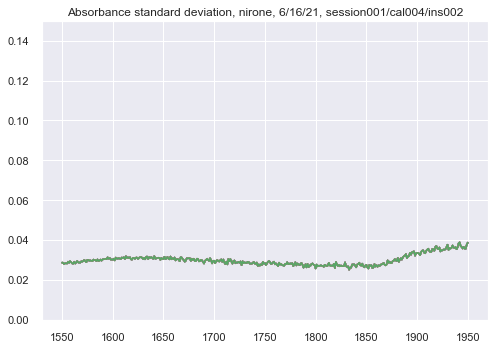

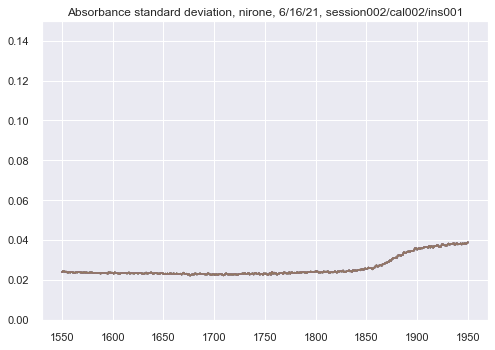

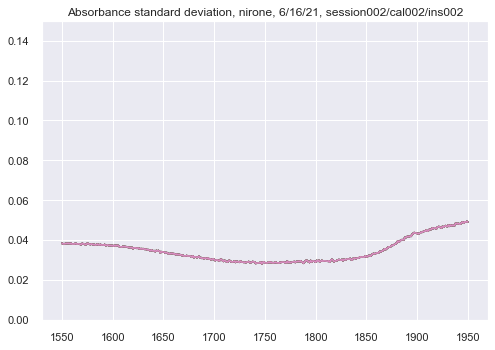

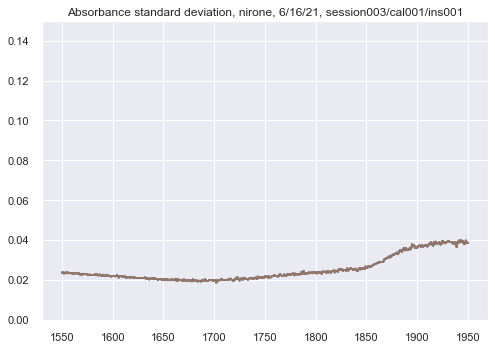

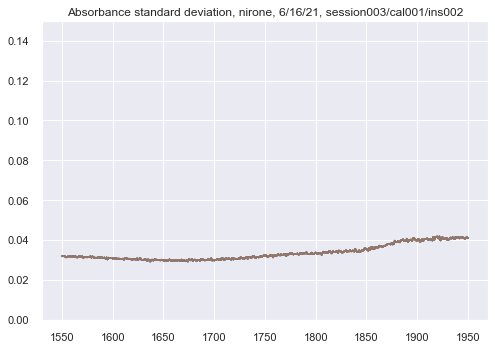

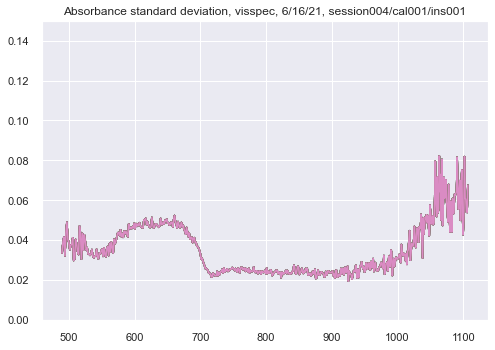

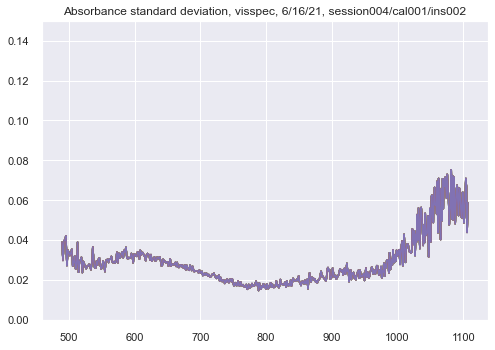

In [7]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name
ftir_min_index = 100
ftir_max_index = 665
depth_min = 5.0
depth_max = 35.0

for index in insertions_list_df.index.values:
    session = insertions_list_df['session'][index]
    calibration = insertions_list_df['calibration'][index]
    insertion = insertions_list_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    insertion_path = f'{session}/{calibration}/{insertion}'
    
    waves = get_ftir_wavelength_vector(file, cal_path)
    
    depths = get_ftir_insertion_spectrum_depths(file, insertion_path)
    depths_good = depths[depths > 5.0]
    
    absorbances = get_ftir_insertion_absorbances(file, insertion_path)
    absorbances_good = absorbances[depths > 5.0]
    
    
    name = get_spectrometer_name(file, session, 2)
    
    if name == 'ftirengine':
        absorbances_good = absorbances_good[:, ftir_min_index:ftir_max_index]
        waves = waves[ftir_min_index:ftir_max_index]
        
    absorbance_mean = np.mean(absorbances_good, axis=0)
    absorbance_sd = np.std(absorbances_good, axis=0)
    absorbance_plus_sd = absorbance_mean + absorbance_sd
    absorbance_minus_sd = absorbance_mean - absorbance_sd
    
    fig, ax = plt.subplots()
    ax.set_title(f"Absorbance standard deviation, {name}, 6/16/21, {insertion_path}")
    ax.set_ylim(0, 0.15)
    for i in range(absorbances_good.shape[0]):
        
        ax.plot(waves, absorbance_sd)
    
    plt.show()
    plt.close()

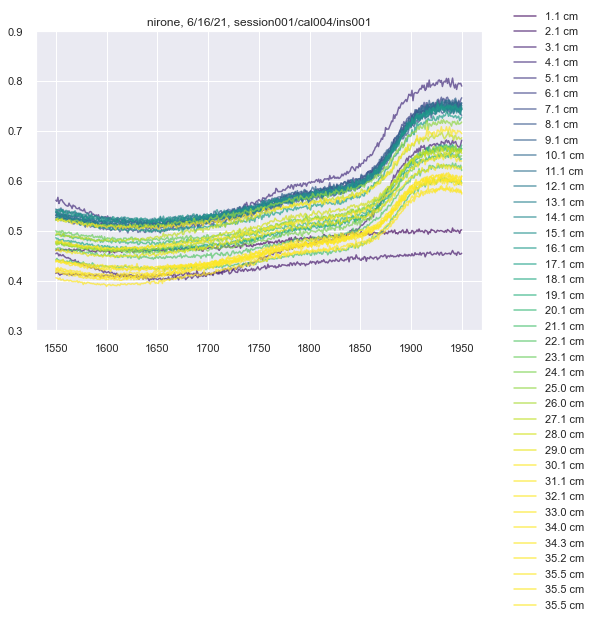

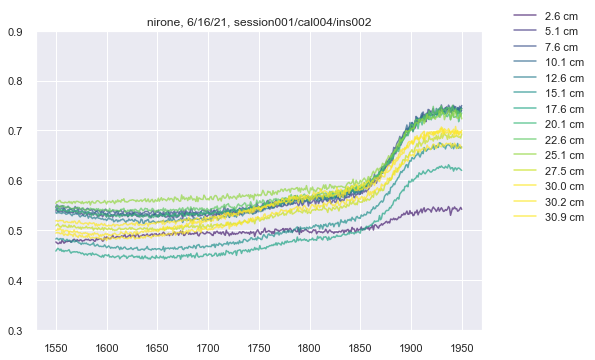

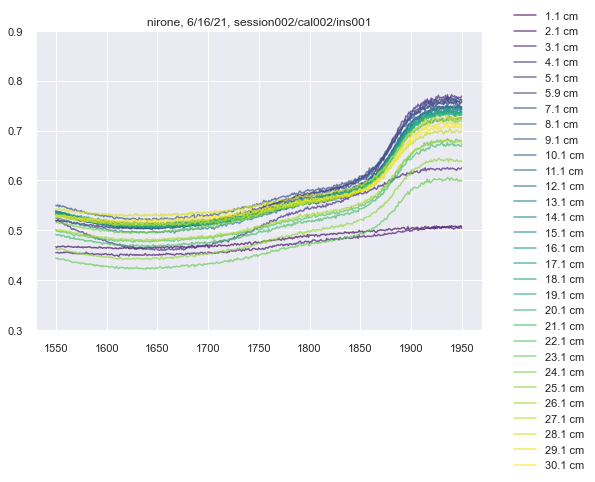

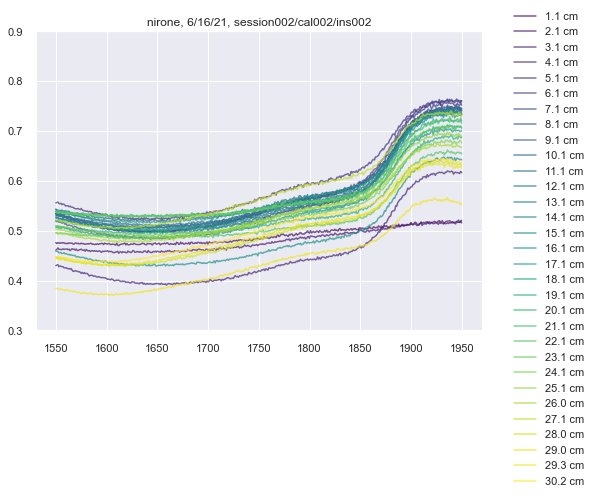

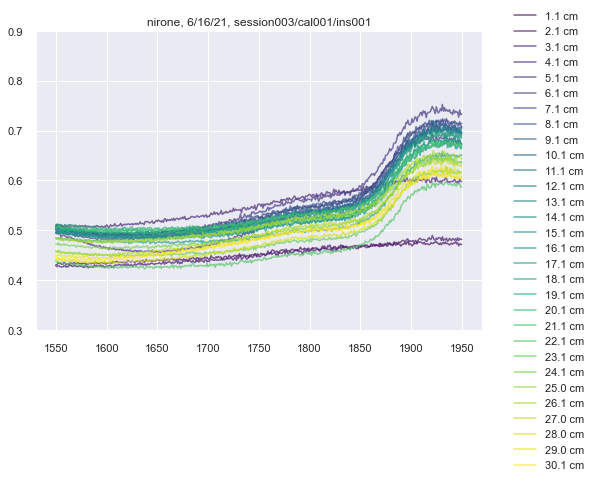

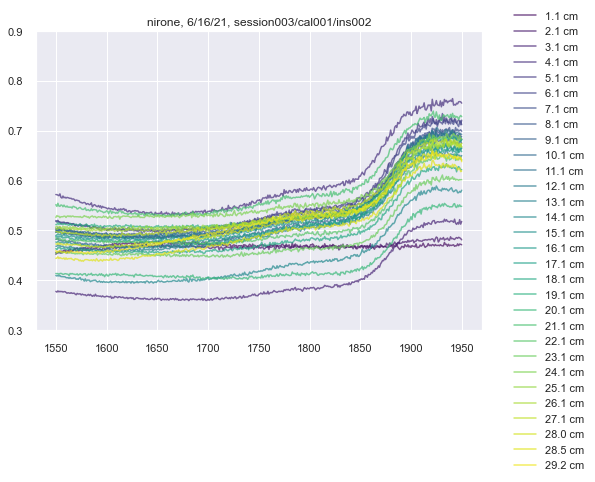

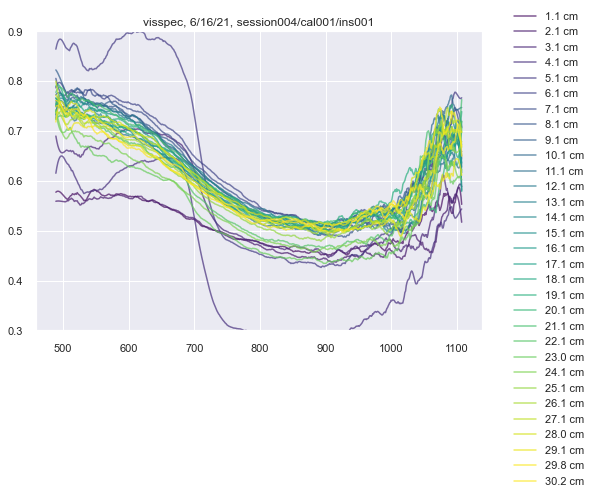

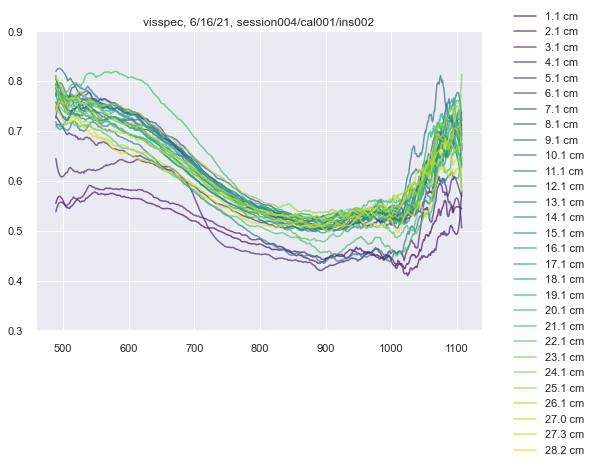

In [8]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name
ftir_min_index = 100
ftir_max_index = 665

for index in insertions_list_df.index.values:
    session = insertions_list_df['session'][index]
    calibration = insertions_list_df['calibration'][index]
    insertion = insertions_list_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    insertion_path = f'{session}/{calibration}/{insertion}'
    
    waves = get_ftir_wavelength_vector(file, cal_path)
    absorbances = get_ftir_insertion_absorbances(file, insertion_path)
    depths = get_ftir_insertion_spectrum_depths(file, insertion_path)
    depth_min = 0.0
    depth_max = 30.0
    name = get_spectrometer_name(file, session, 2)
    
    if name == 'ftirengine':
        absorbances = absorbances[:, ftir_min_index:ftir_max_index]
        waves = waves[ftir_min_index:ftir_max_index]
    
    fig, ax = plt.subplots()
    ax.set_title(f"{name}, 6/16/21, {insertion_path}")
    ax.set_ylim(0.3, 0.9)
    for i in range(absorbances.shape[0]):
        color = plt.cm.viridis(normalize_depth(depths[i], depth_min, depth_max))
        if name == 'visspec':
            ax.plot(waves, savgol_filter(absorbances[i, :], 21, 3), 
                    color=color, alpha=0.7, label=f'{depths[i]:0.1f} cm')
        else:
            ax.plot(waves, absorbances[i, :], 
                    color=color, alpha=0.7, label=f'{depths[i]:0.1f} cm')
    plt.legend(bbox_to_anchor=(1.05, 0.9, 0.3, 0.2), loc='upper left')
    plt.show()
    plt.close()

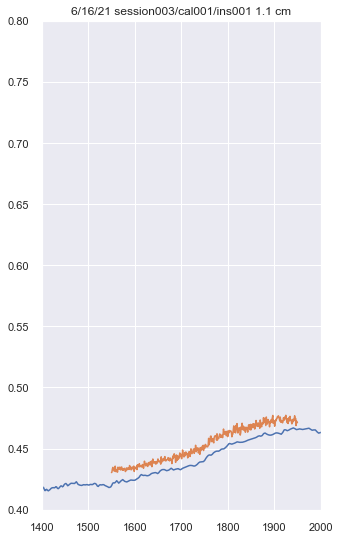

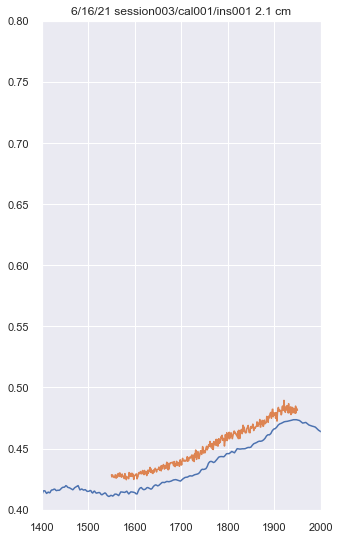

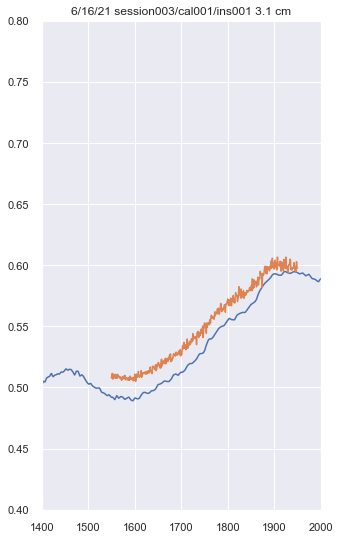

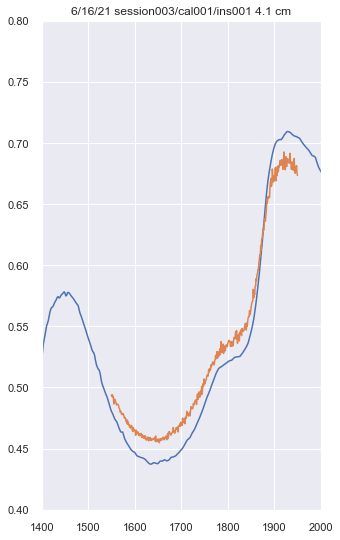

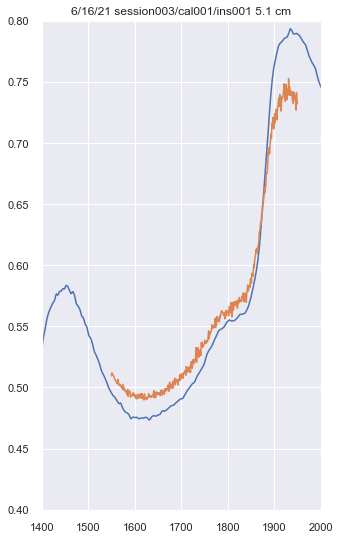

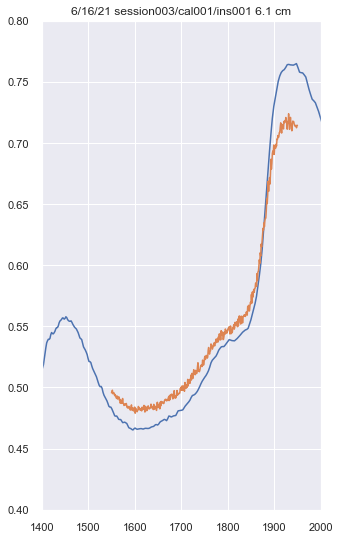

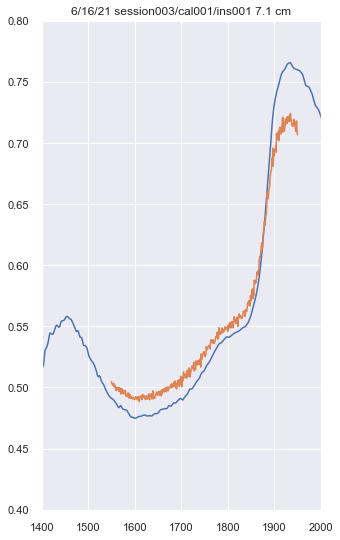

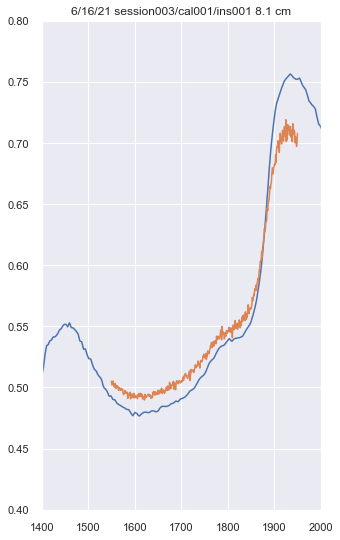

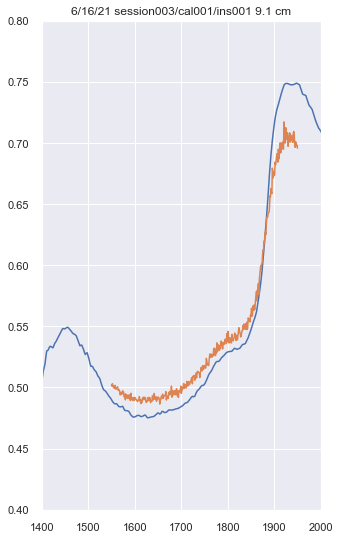

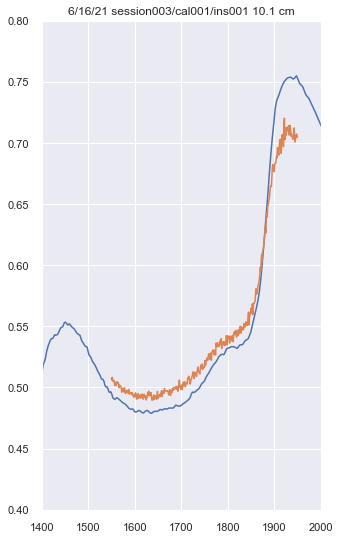

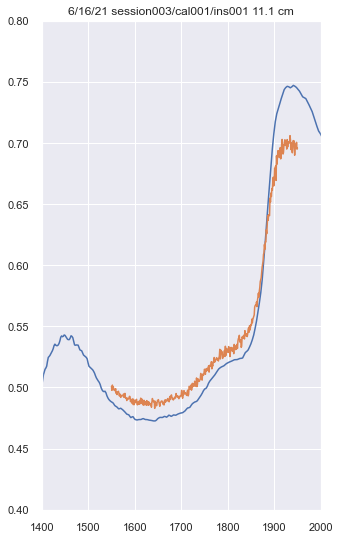

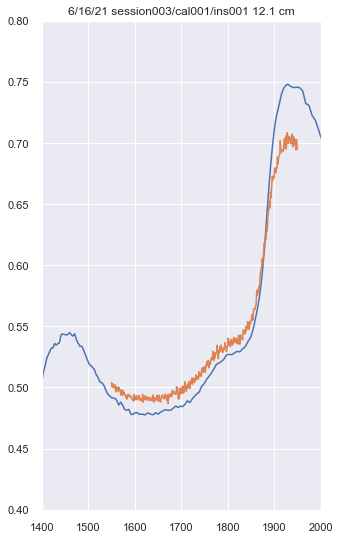

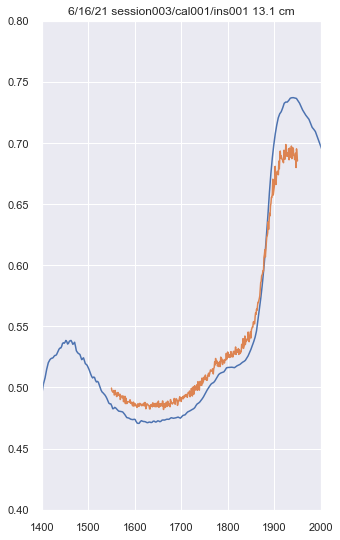

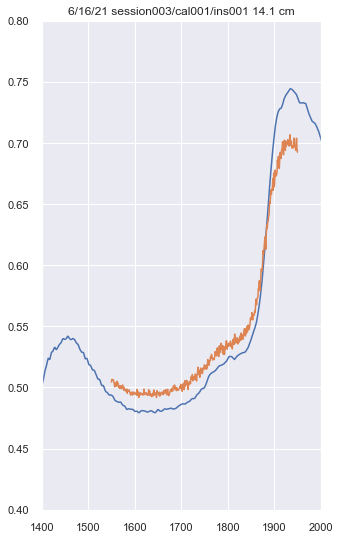

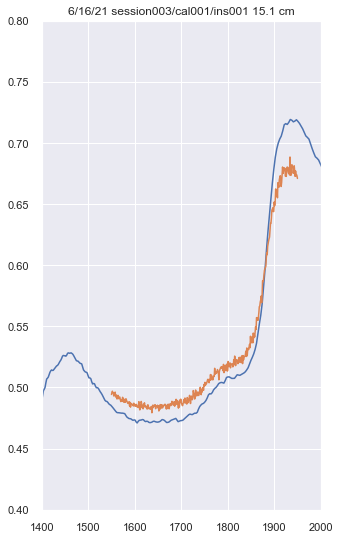

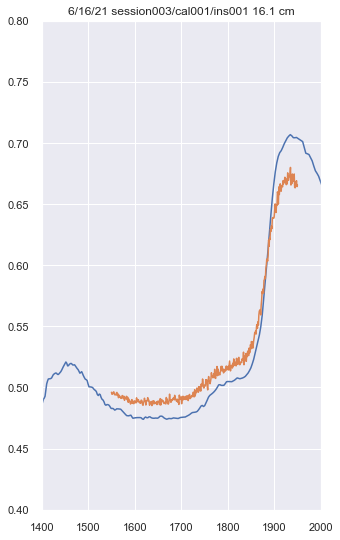

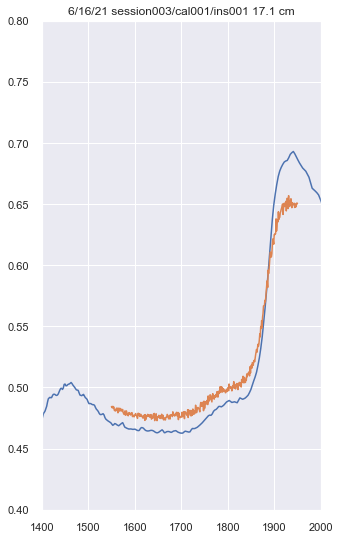

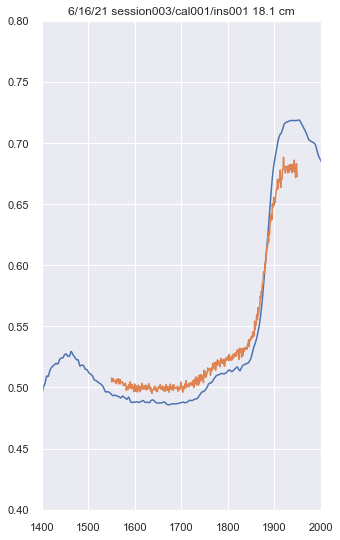

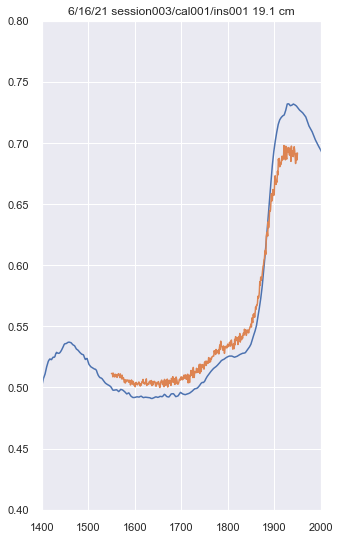

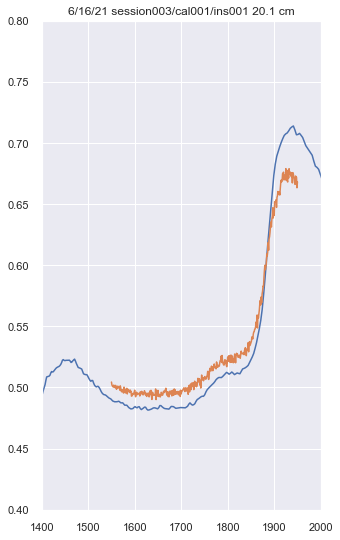

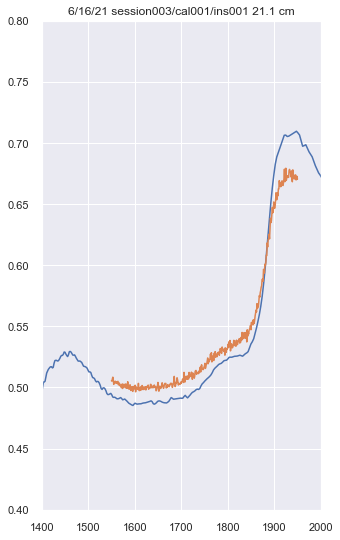

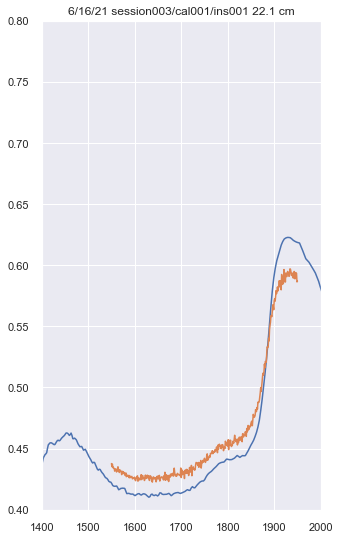

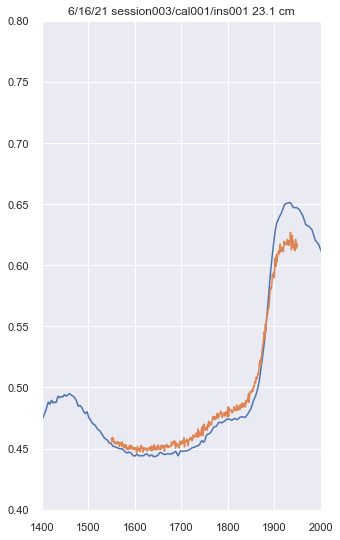

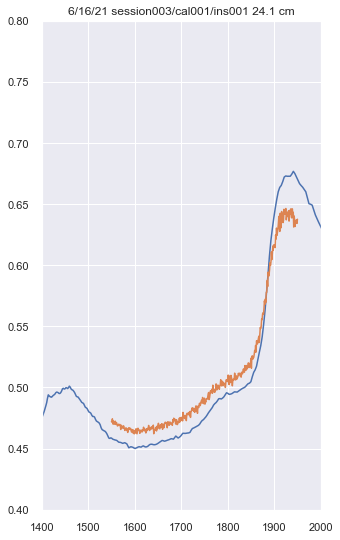

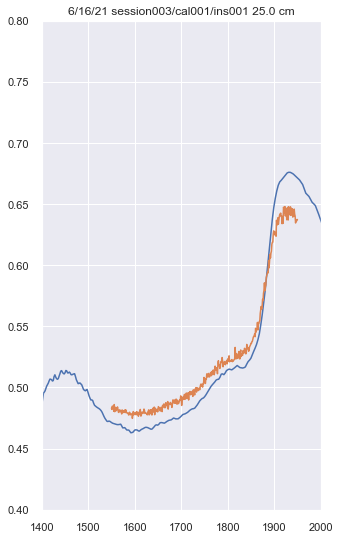

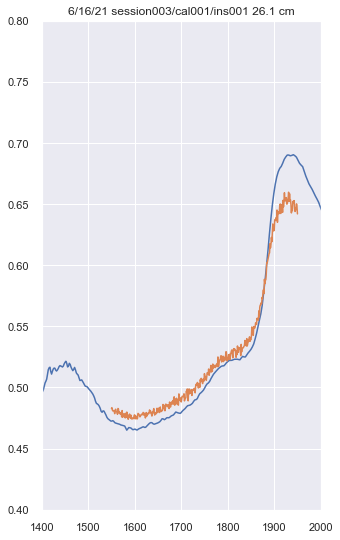

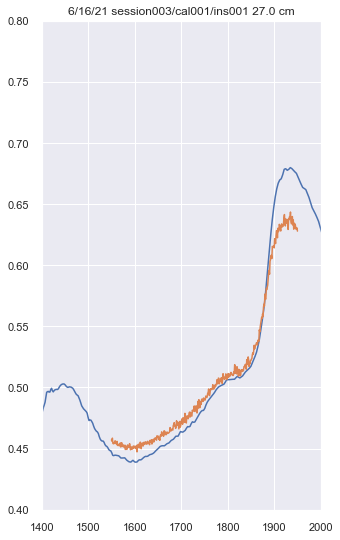

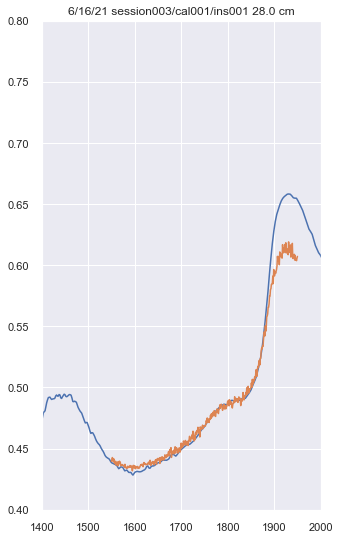

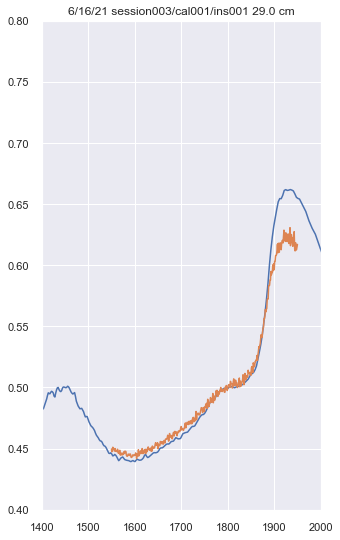

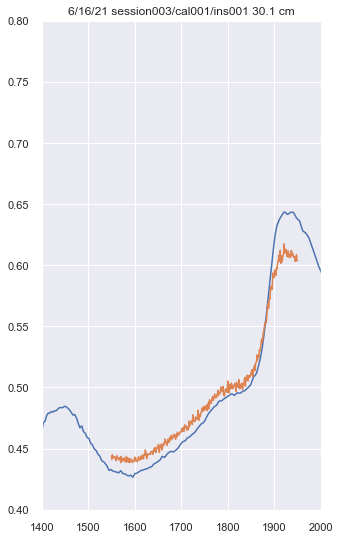

In [9]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name
ftir_min_index = 100
ftir_max_index = 665

depth_min = 0.0
depth_max = 35.0

session = 'session003'
calibration = 'cal001'
insertion = 'ins001'
cal_path = f'{session}/{calibration}'
insertion_path = f'{session}/{calibration}/{insertion}'

ftir_waves = get_visible_wavelength_vector(file, cal_path)
ftir_waves = ftir_waves[ftir_min_index:ftir_max_index]
ftir_absorbances = get_visible_insertion_absorbances(file, insertion_path)
ftir_absorbances = ftir_absorbances[:, ftir_min_index:ftir_max_index]
ftir_depths = get_visible_insertion_spectrum_depths(file, insertion_path)

nirone_waves = get_ftir_wavelength_vector(file, cal_path)
nirone_absorbances = get_ftir_insertion_absorbances(file, insertion_path)
nirone_depths = get_ftir_insertion_spectrum_depths(file, insertion_path)


for i in range(ftir_depths.shape[0]):
    fig, ax = plt.subplots(figsize=(5, 9))
    ax.set_title(f'6/16/21 {session}/{calibration}/{insertion} {ftir_depths[i]:0.1f} cm')
    ax.set_ylim(0.4, 0.8)
    ax.set_xlim(1400, 2000)
    ax.plot(ftir_waves, ftir_absorbances[i, :])
    ax.plot(nirone_waves, nirone_absorbances[i, :])
    plt.show()
    plt.close()


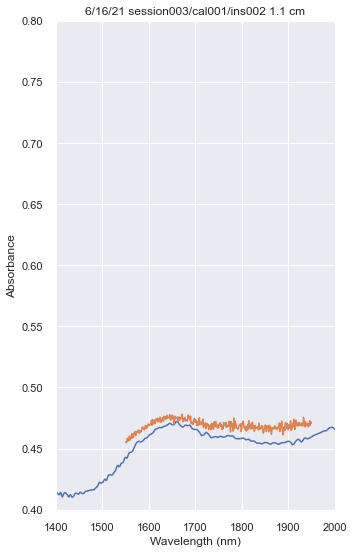

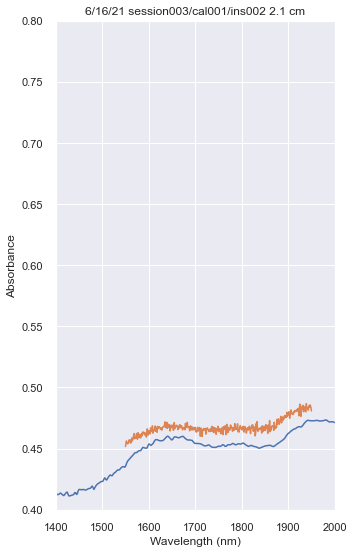

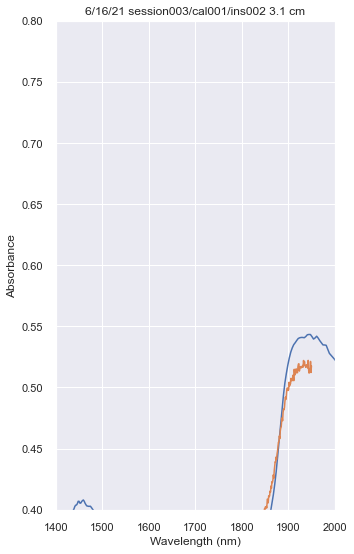

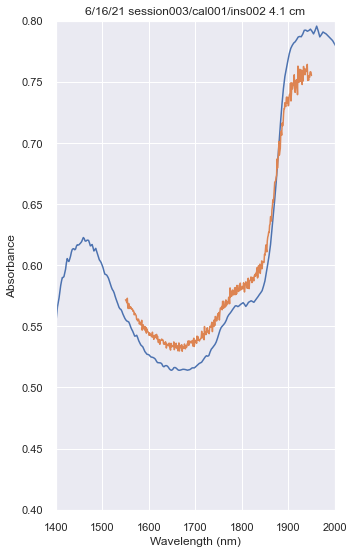

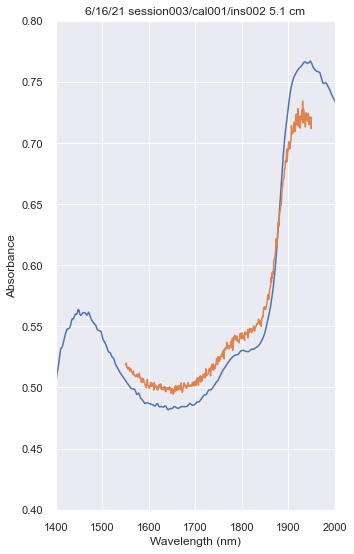

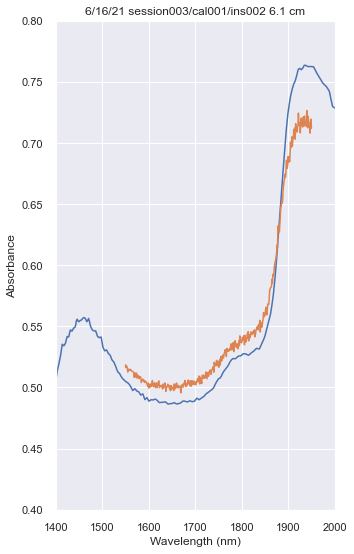

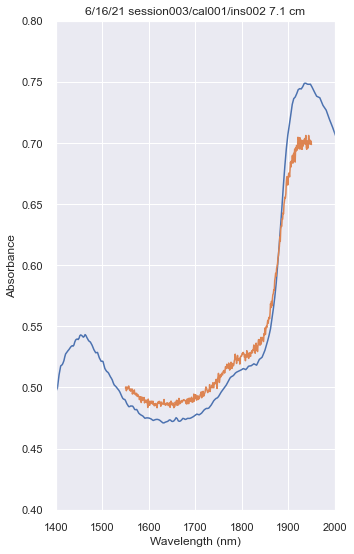

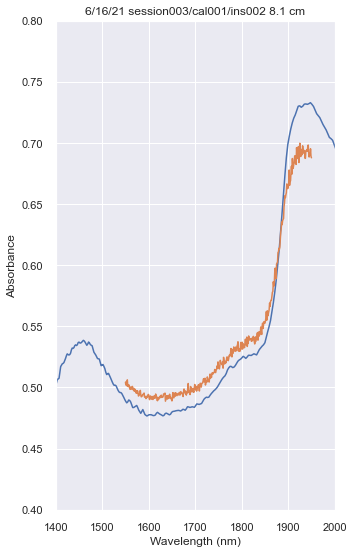

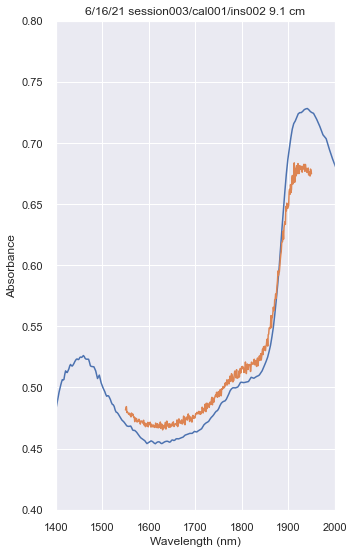

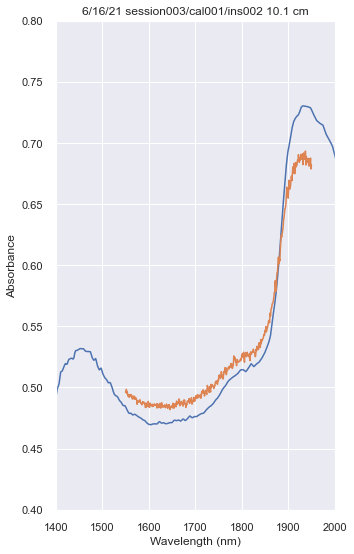

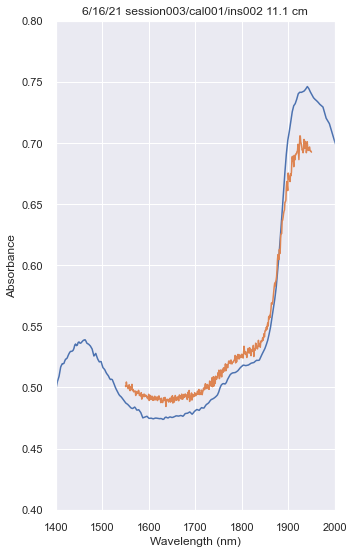

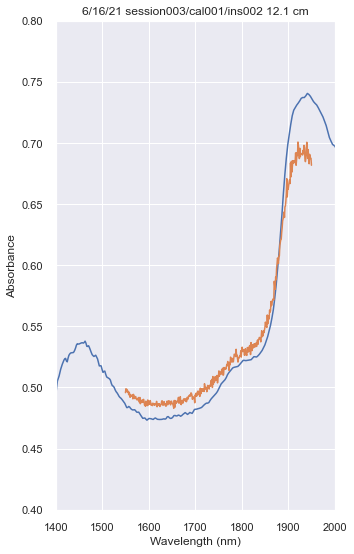

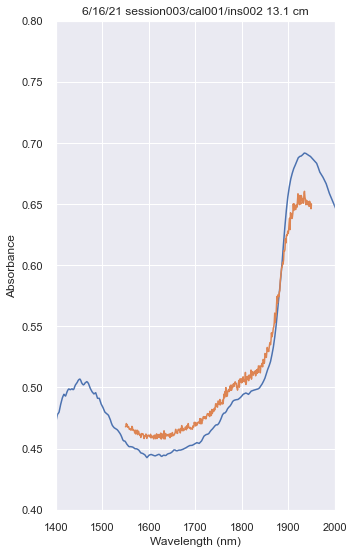

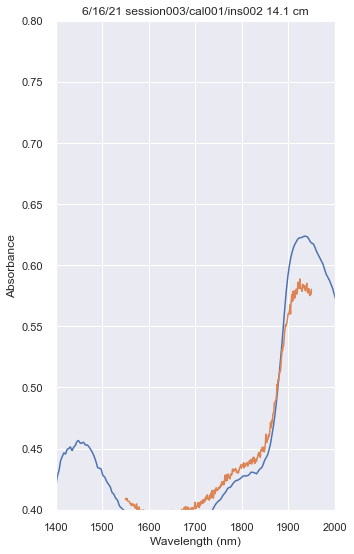

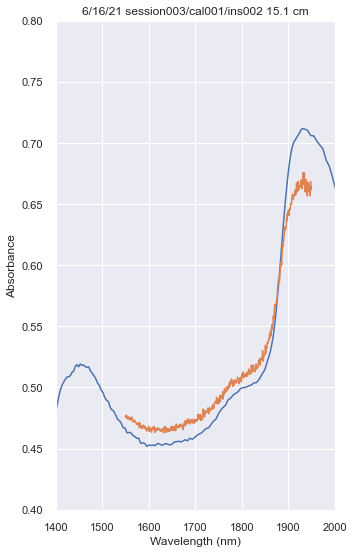

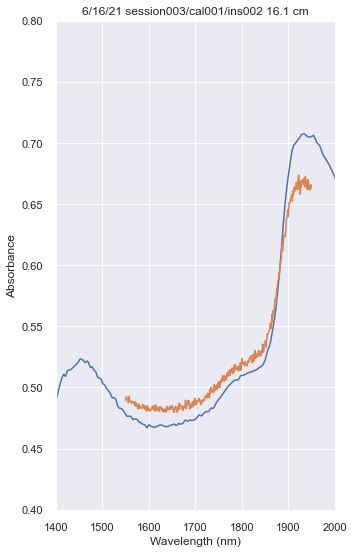

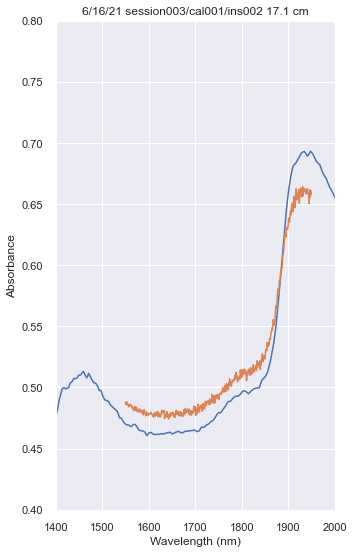

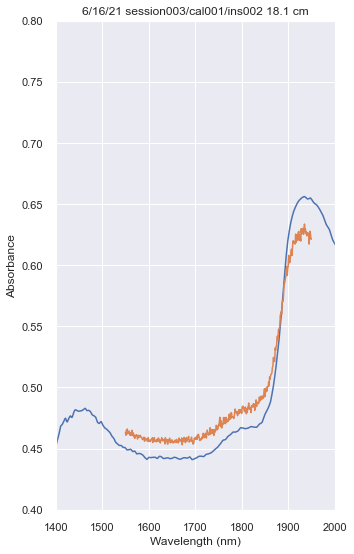

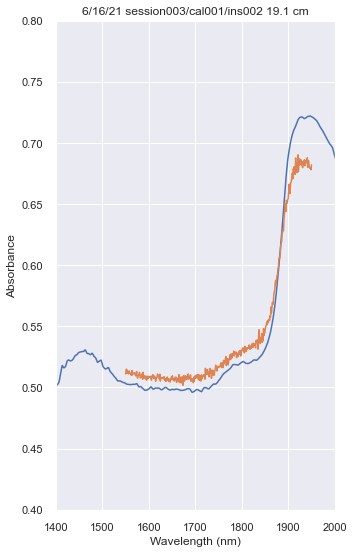

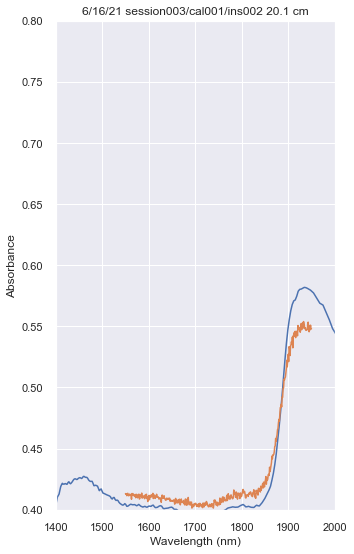

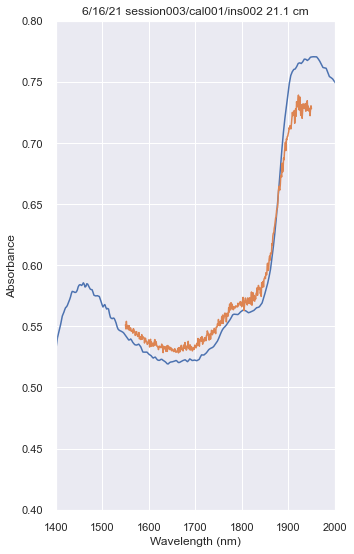

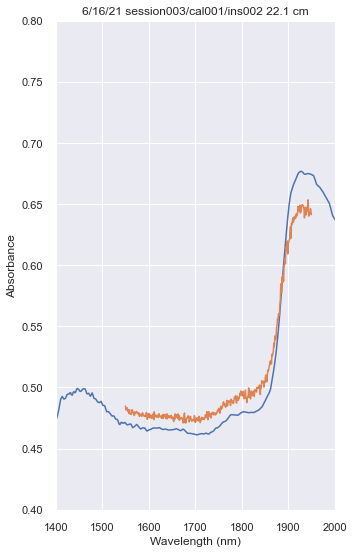

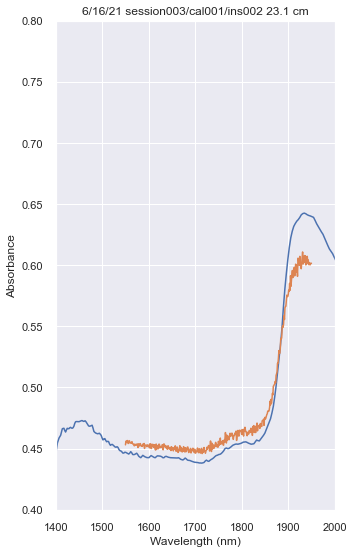

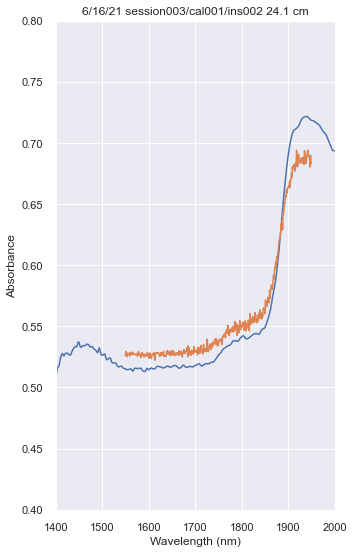

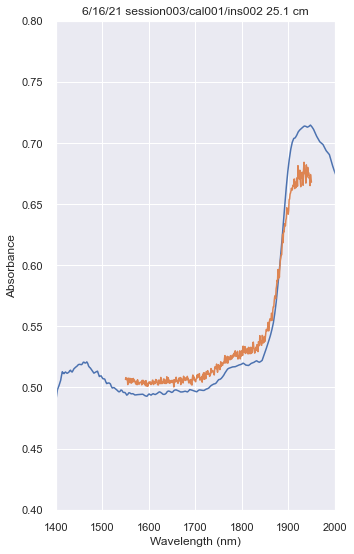

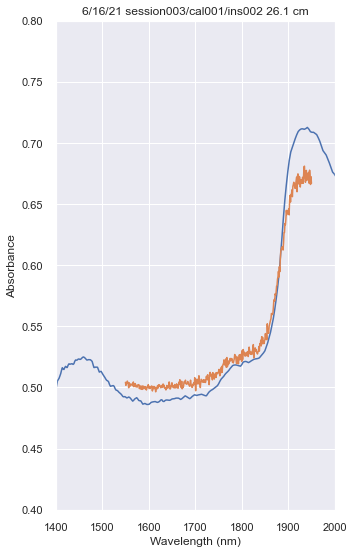

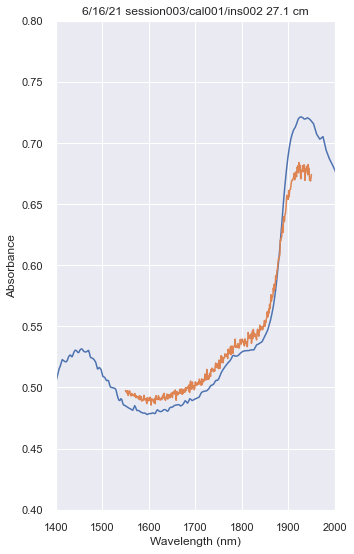

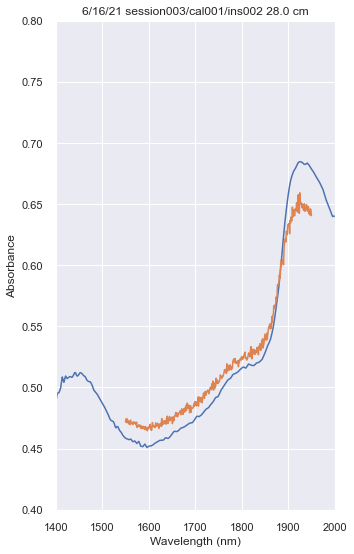

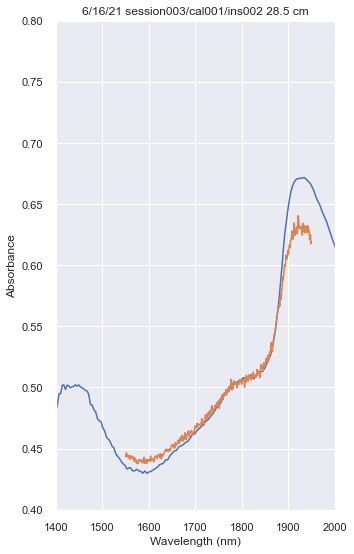

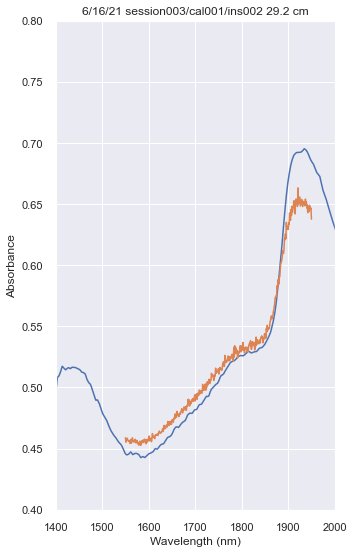

In [10]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name
ftir_min_index = 100
ftir_max_index = 665

depth_min = 0.0
depth_max = 35.0

session = 'session003'
calibration = 'cal001'
insertion = 'ins002'
cal_path = f'{session}/{calibration}'
insertion_path = f'{session}/{calibration}/{insertion}'

ftir_waves = get_visible_wavelength_vector(file, cal_path)
ftir_waves = ftir_waves[ftir_min_index:ftir_max_index]
ftir_absorbances = get_visible_insertion_absorbances(file, insertion_path)
ftir_absorbances = ftir_absorbances[:, ftir_min_index:ftir_max_index]
ftir_depths = get_visible_insertion_spectrum_depths(file, insertion_path)

nirone_waves = get_ftir_wavelength_vector(file, cal_path)
nirone_absorbances = get_ftir_insertion_absorbances(file, insertion_path)
nirone_depths = get_ftir_insertion_spectrum_depths(file, insertion_path)


for i in range(ftir_depths.shape[0]):
    fig, ax = plt.subplots(figsize=(5, 9))
    ax.set_title(f'6/16/21 {session}/{calibration}/{insertion} {ftir_depths[i]:0.1f} cm')
    ax.set_ylim(0.4, 0.8)
    ax.set_xlim(1400, 2000)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Absorbance")
    ax.plot(ftir_waves, ftir_absorbances[i, :])
    ax.plot(nirone_waves, nirone_absorbances[i, :])
    plt.show()
    plt.close()

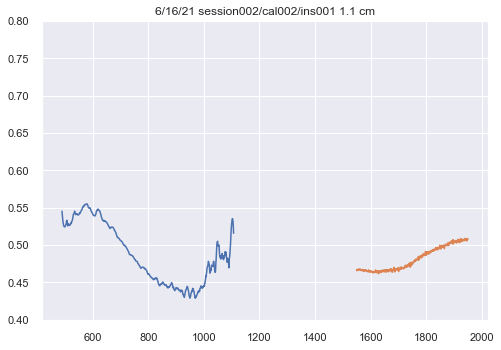

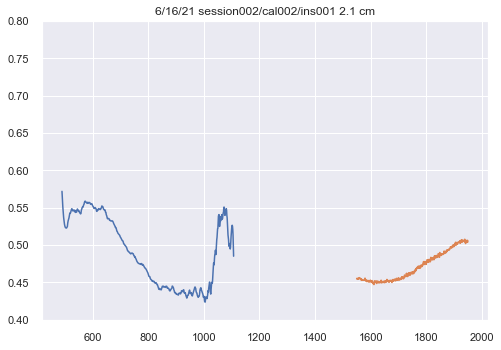

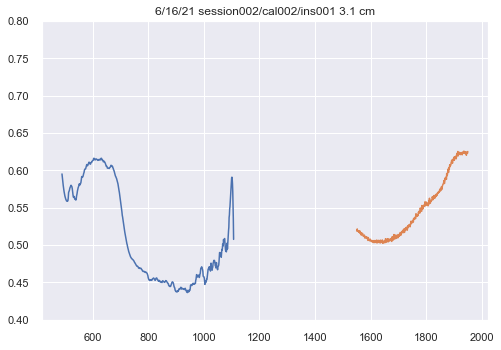

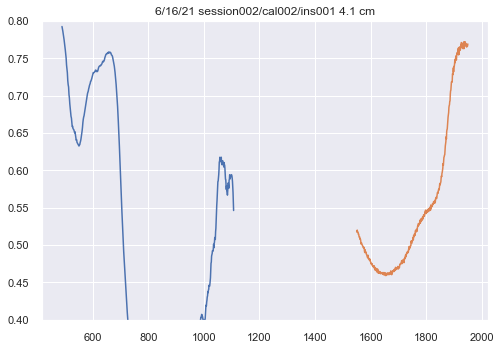

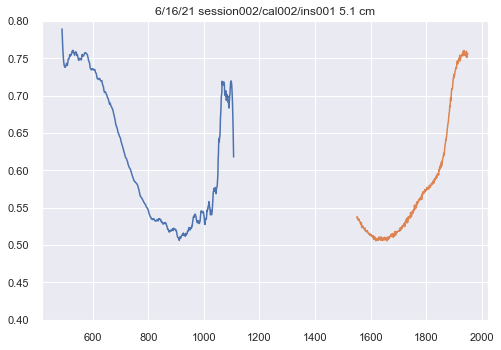

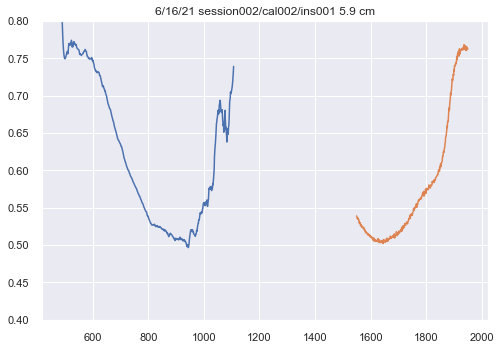

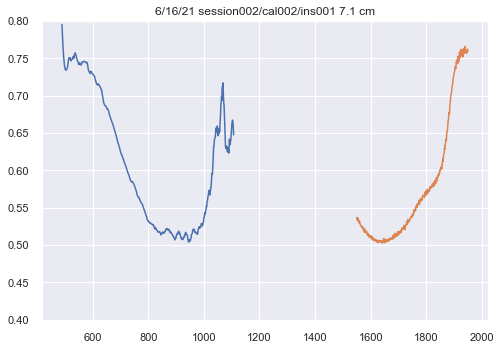

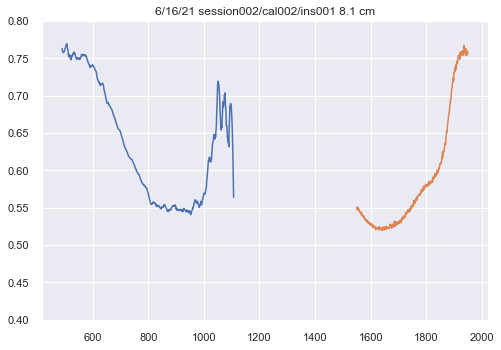

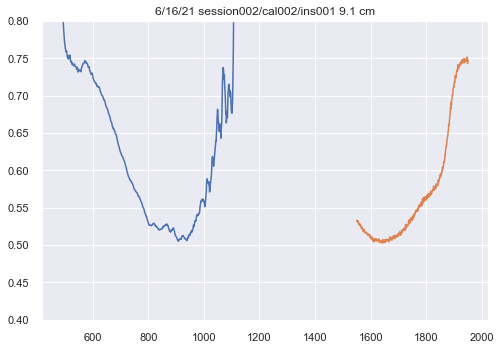

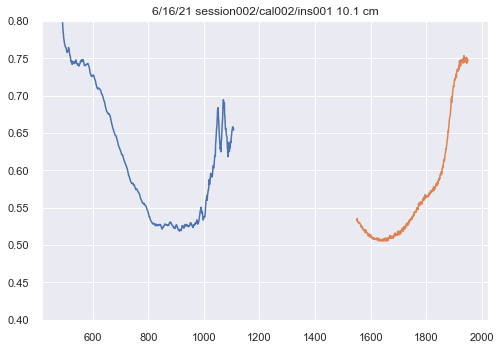

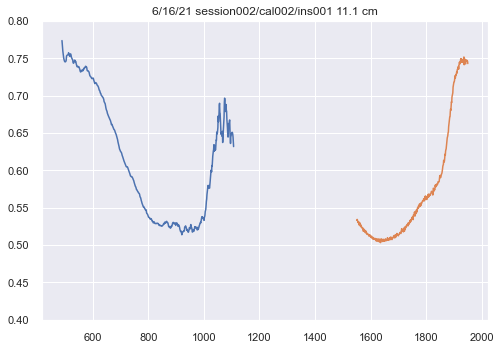

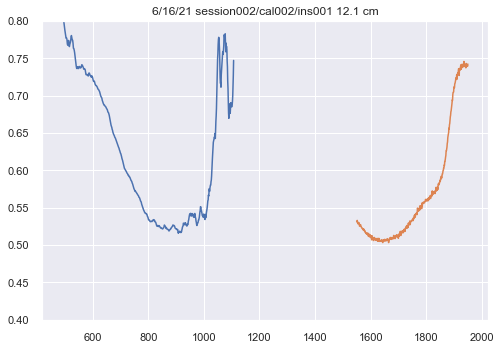

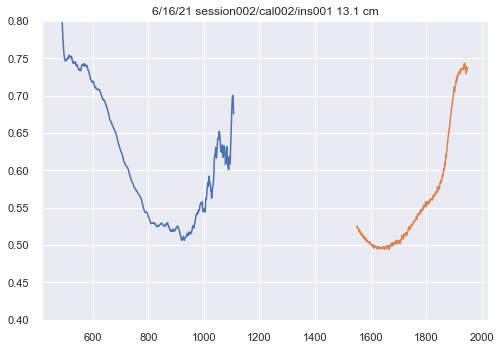

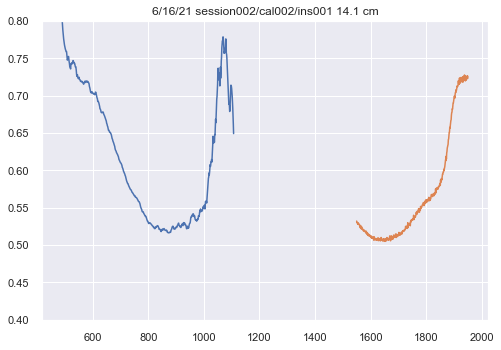

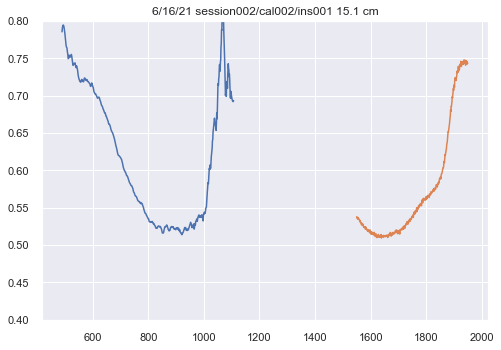

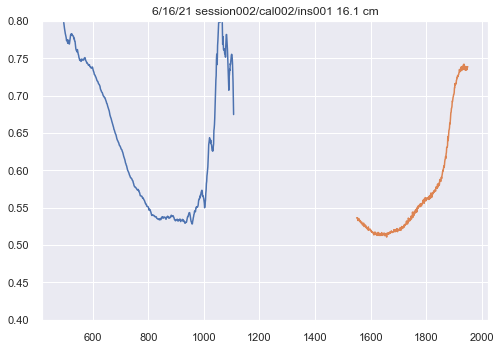

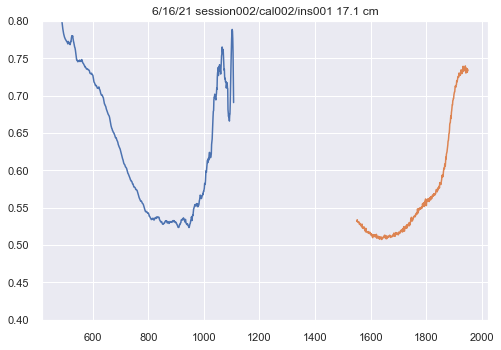

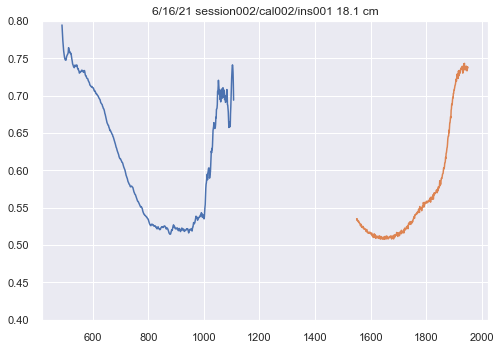

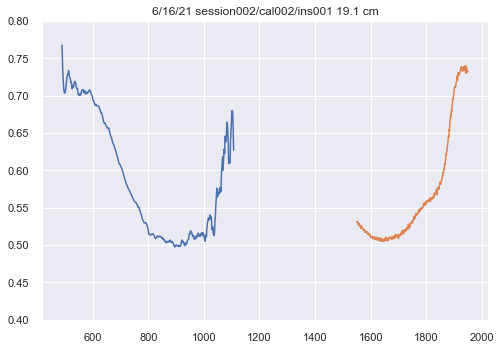

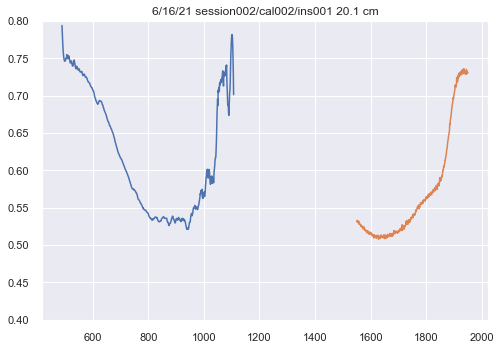

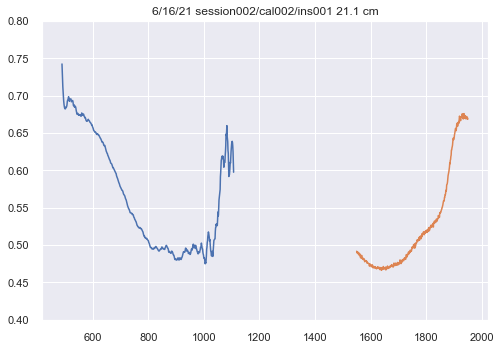

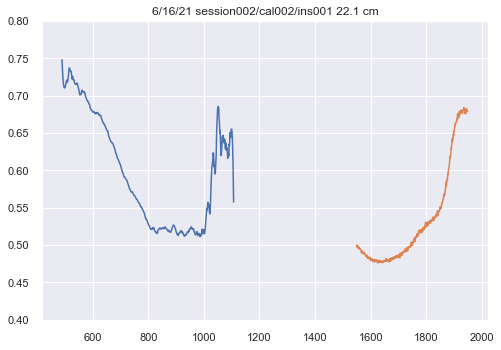

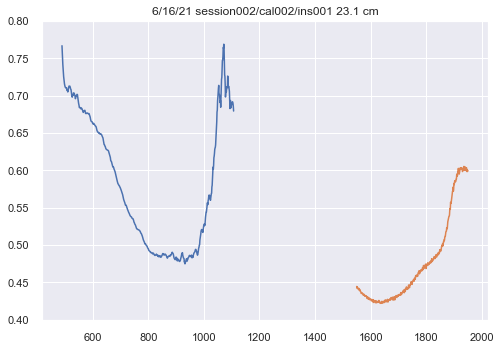

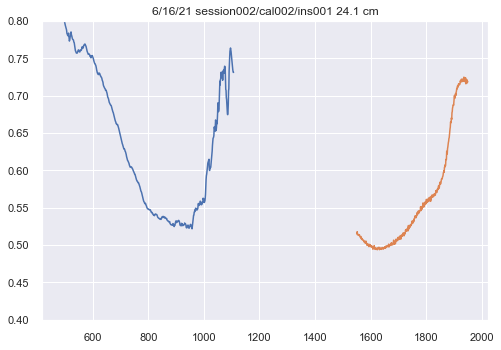

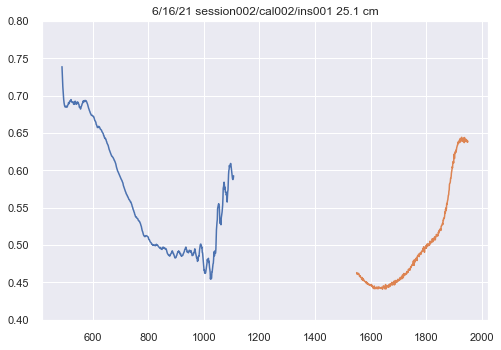

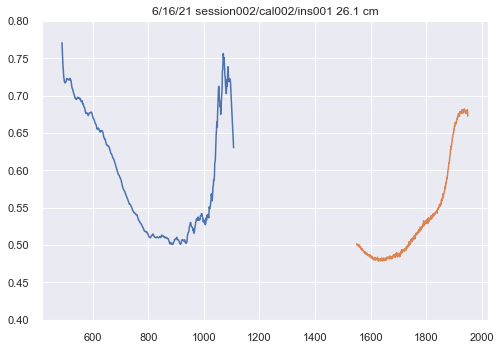

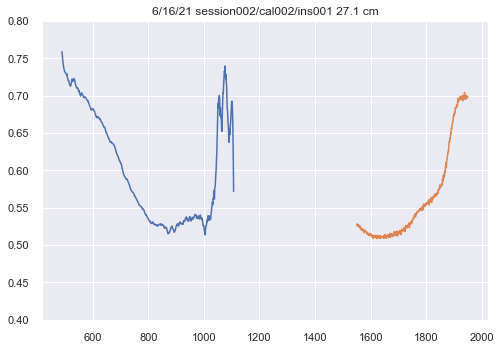

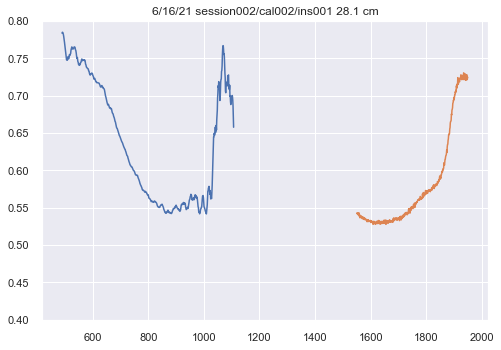

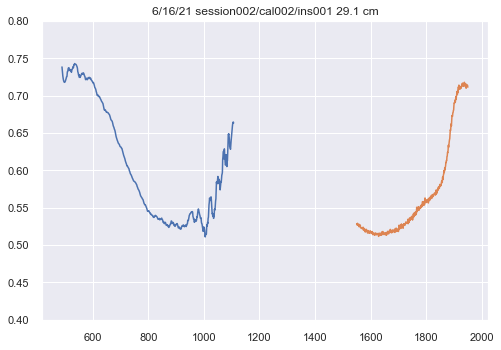

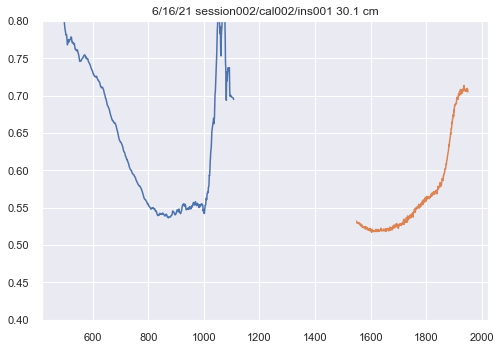

In [11]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name

depth_min = 0.0
depth_max = 35.0

session = 'session002'
calibration = 'cal002'
insertion = 'ins001'
cal_path = f'{session}/{calibration}'
insertion_path = f'{session}/{calibration}/{insertion}'

vis_waves = get_visible_wavelength_vector(file, cal_path)
vis_absorbances = get_visible_insertion_absorbances(file, insertion_path)
vis_depths = get_visible_insertion_spectrum_depths(file, insertion_path)

nirone_waves = get_ftir_wavelength_vector(file, cal_path)
nirone_absorbances = get_ftir_insertion_absorbances(file, insertion_path)
nirone_depths = get_ftir_insertion_spectrum_depths(file, insertion_path)


for i in range(vis_depths.shape[0]):
    fig, ax = plt.subplots()
    ax.set_title(f'6/16/21 {session}/{calibration}/{insertion} {vis_depths[i]:0.1f} cm')
    ax.set_ylim(0.4, 0.8)    
    ax.plot(vis_waves, savgol_filter(vis_absorbances[i, :], 21, 3))
    ax.plot(nirone_waves, nirone_absorbances[i, :])
    plt.show()
    plt.close()

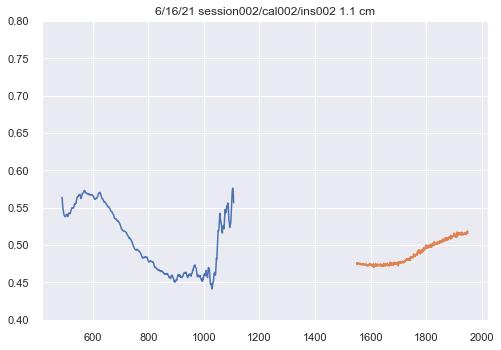

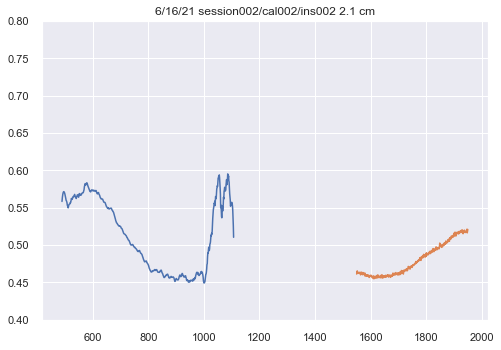

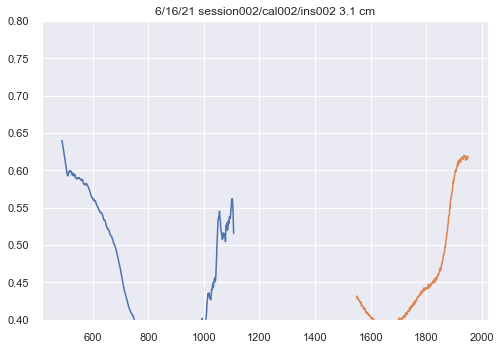

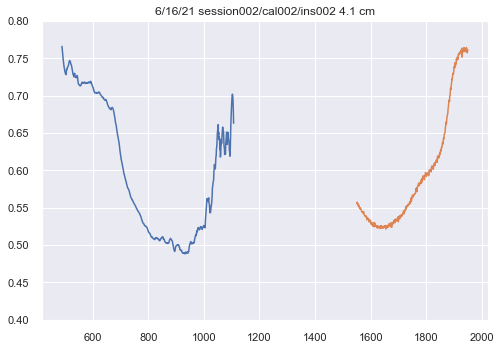

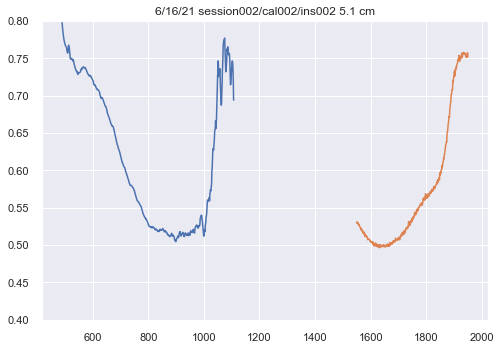

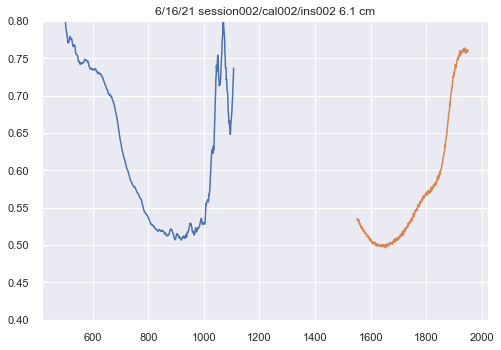

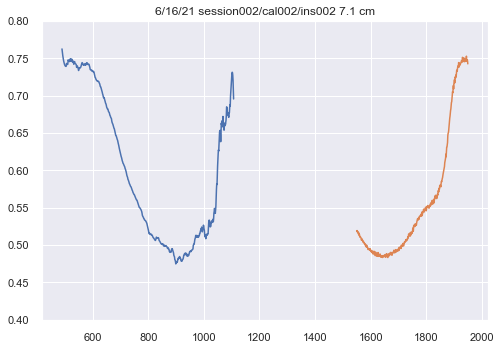

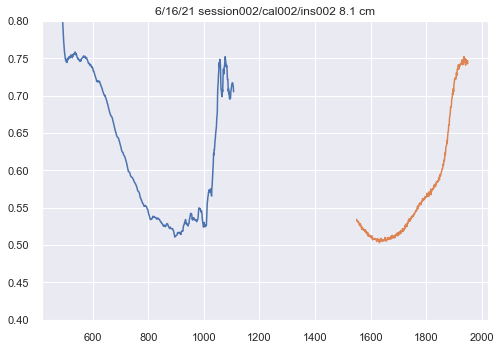

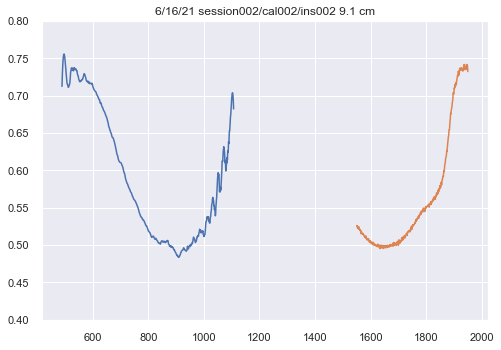

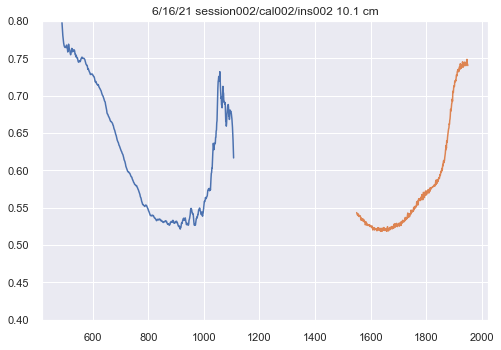

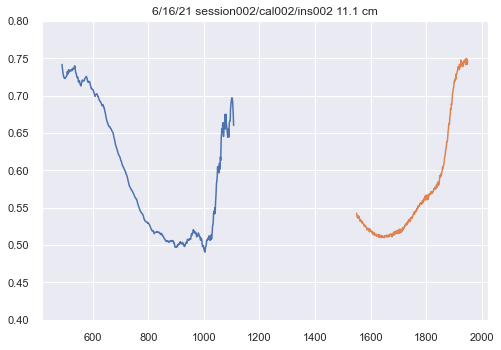

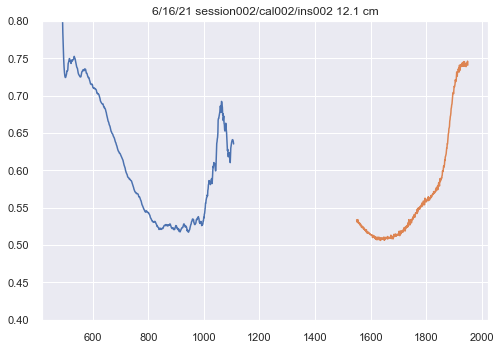

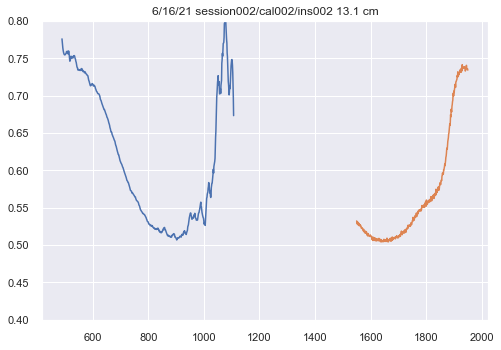

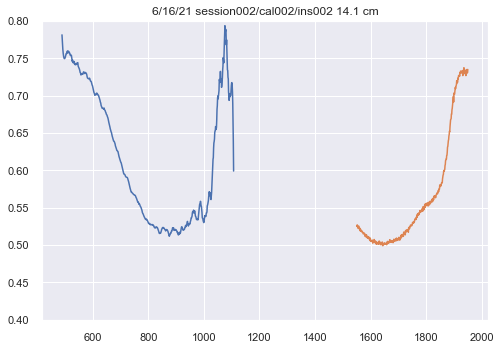

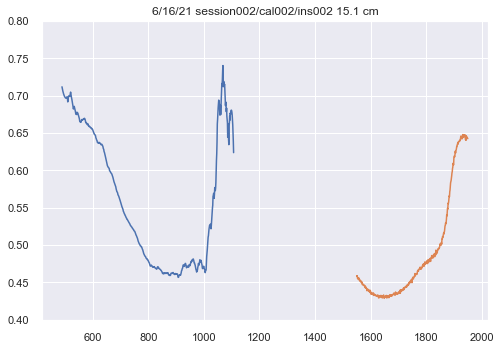

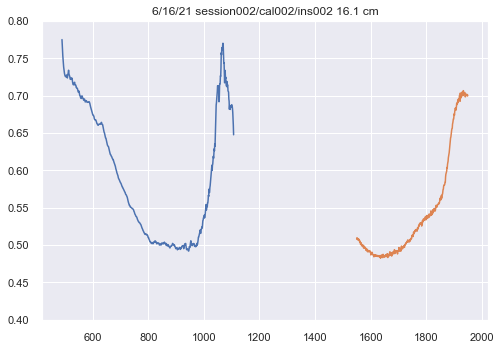

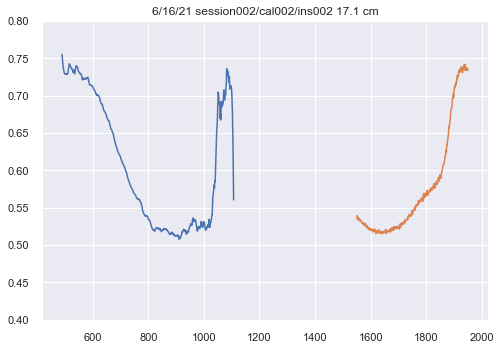

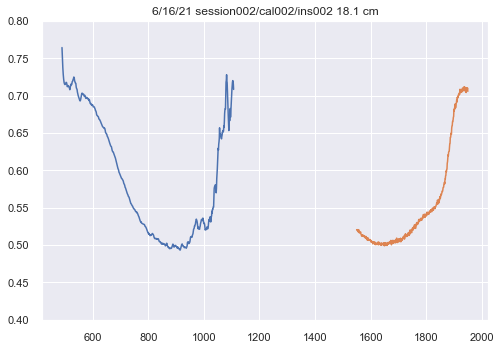

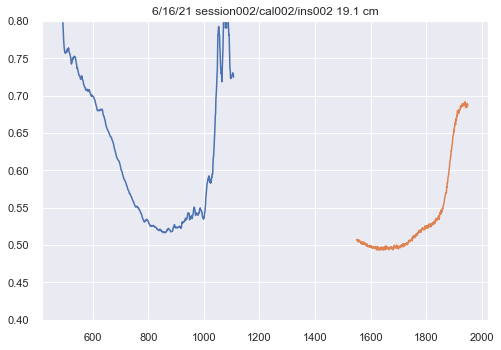

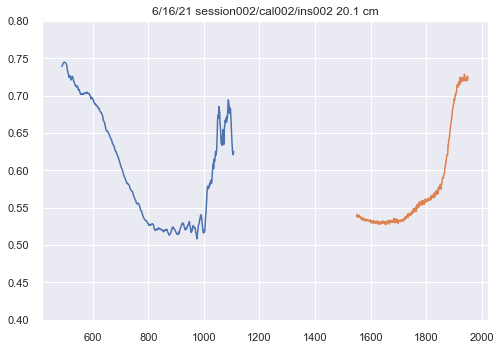

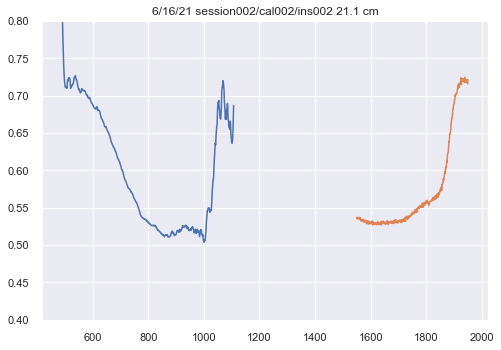

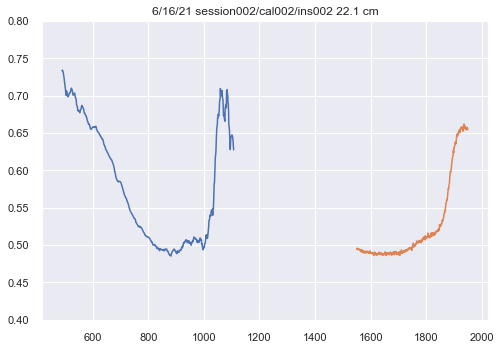

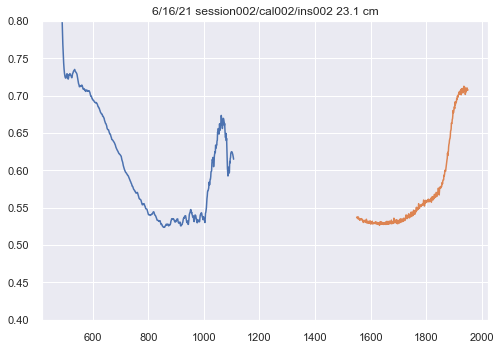

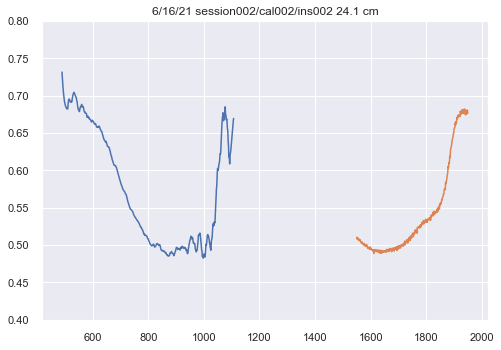

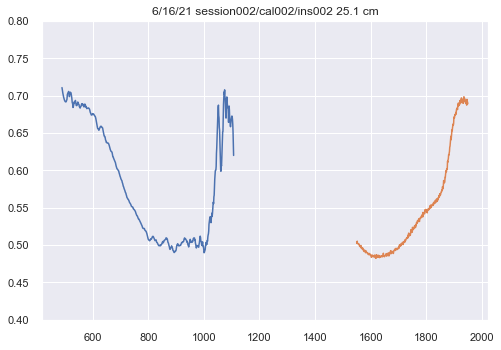

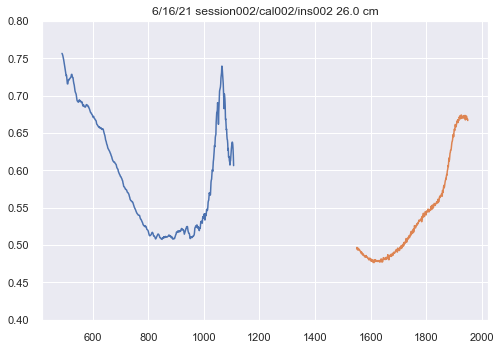

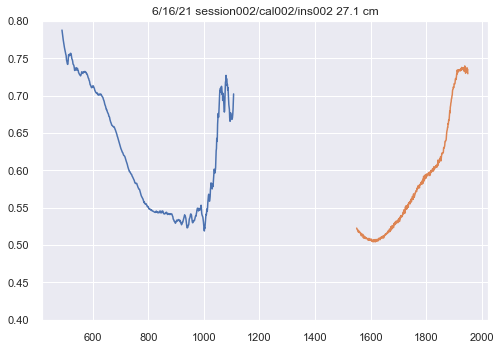

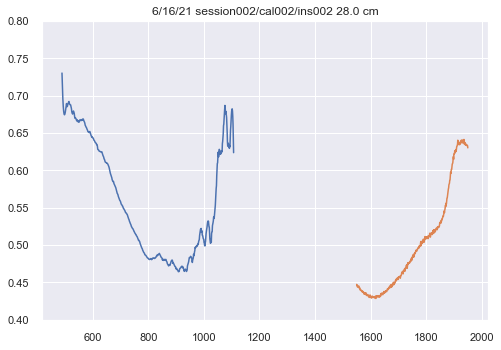

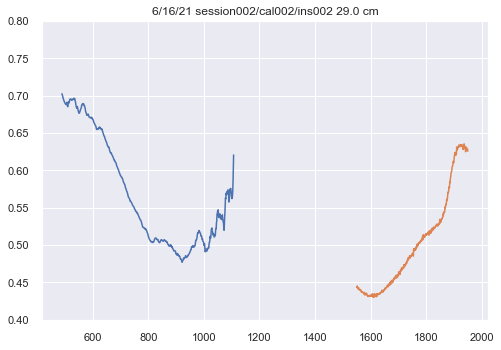

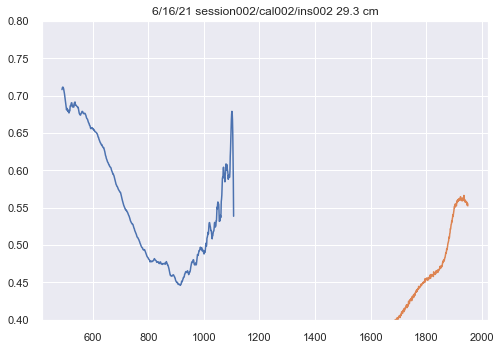

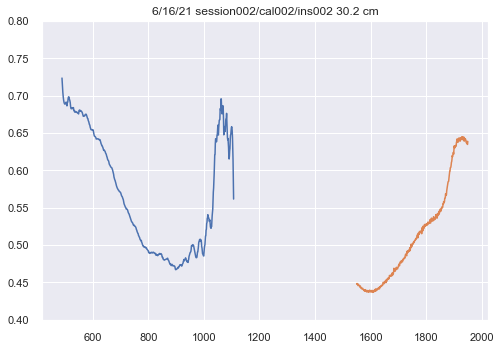

In [12]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name

depth_min = 0.0
depth_max = 35.0

session = 'session002'
calibration = 'cal002'
insertion = 'ins002'
cal_path = f'{session}/{calibration}'
insertion_path = f'{session}/{calibration}/{insertion}'

vis_waves = get_visible_wavelength_vector(file, cal_path)
vis_absorbances = get_visible_insertion_absorbances(file, insertion_path)
vis_depths = get_visible_insertion_spectrum_depths(file, insertion_path)

nirone_waves = get_ftir_wavelength_vector(file, cal_path)
nirone_absorbances = get_ftir_insertion_absorbances(file, insertion_path)
nirone_depths = get_ftir_insertion_spectrum_depths(file, insertion_path)


for i in range(vis_depths.shape[0]):
    fig, ax = plt.subplots()
    ax.set_title(f'6/16/21 {session}/{calibration}/{insertion} {vis_depths[i]:0.1f} cm')
    ax.set_ylim(0.4, 0.8)    
    ax.plot(vis_waves, savgol_filter(vis_absorbances[i, :], 21, 3))
    ax.plot(nirone_waves, nirone_absorbances[i, :])
    plt.show()
    plt.close()

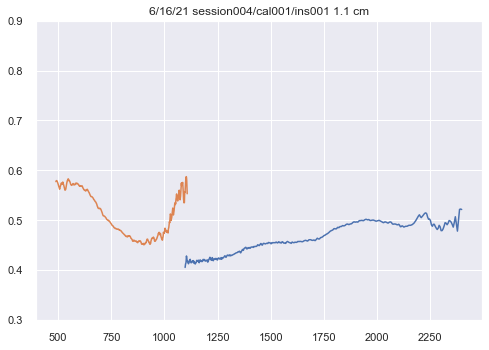

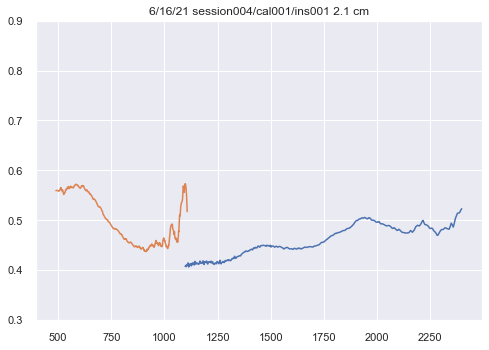

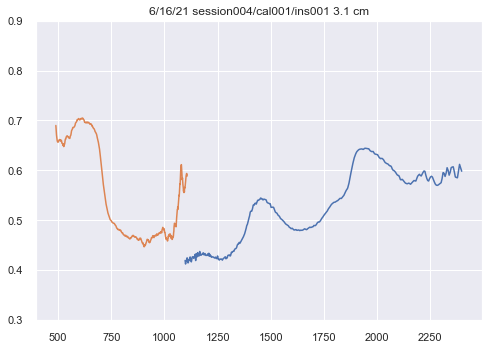

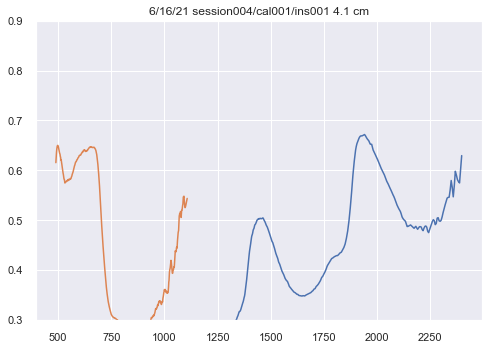

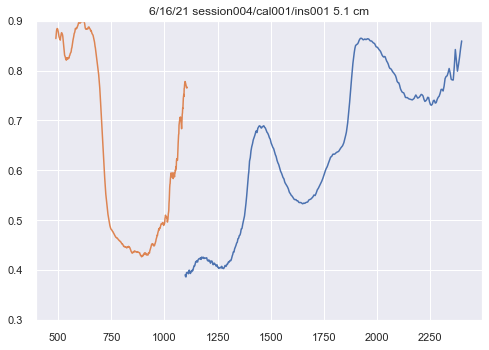

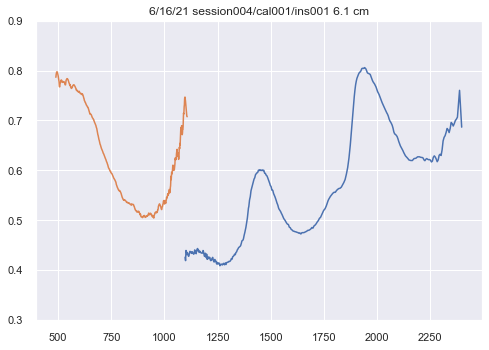

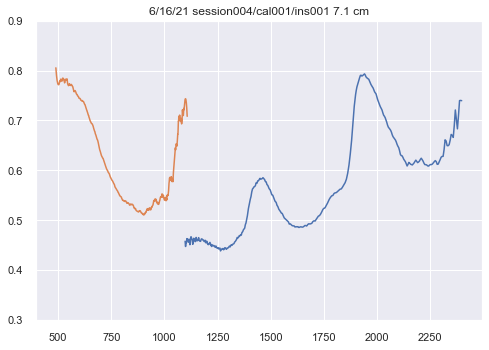

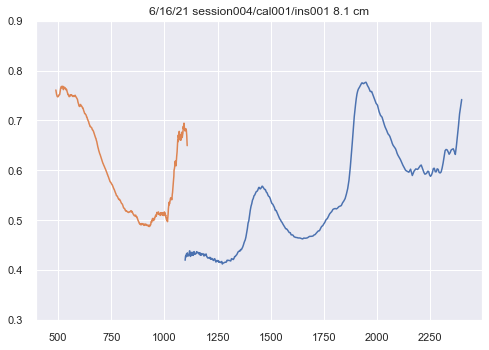

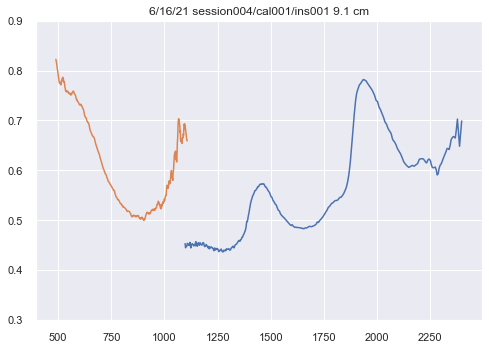

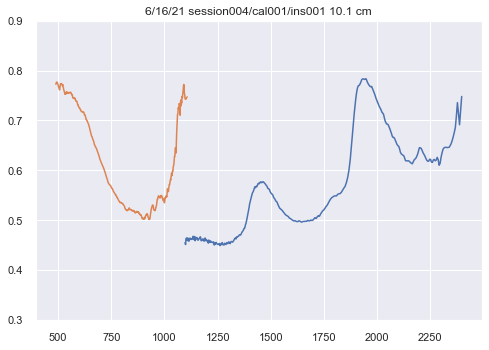

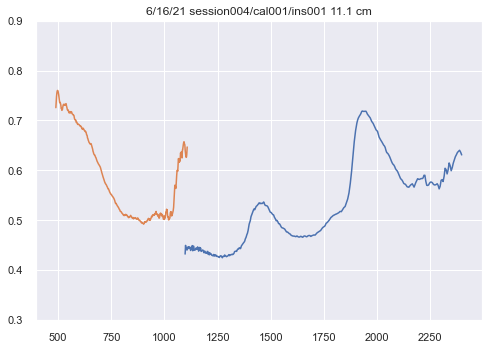

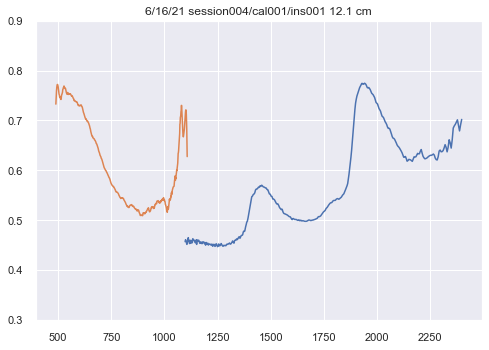

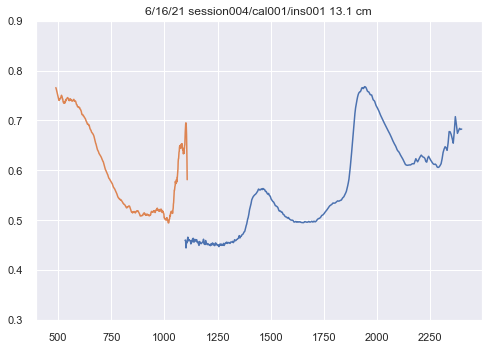

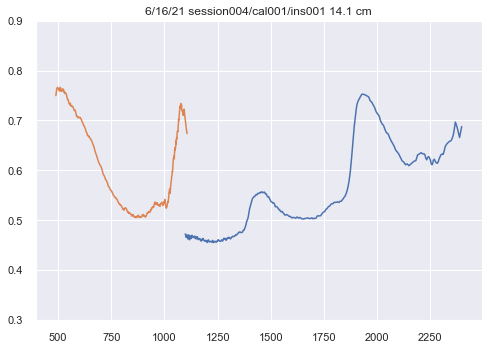

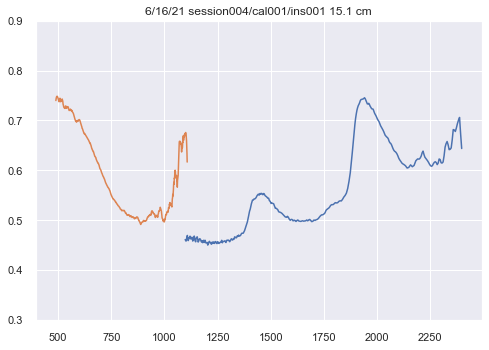

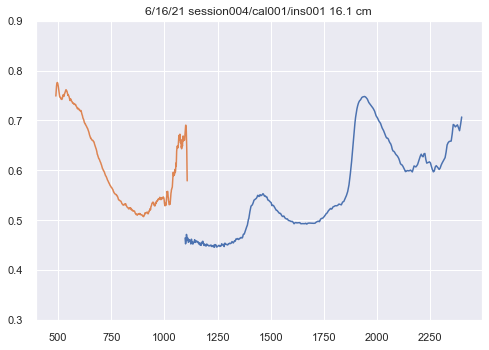

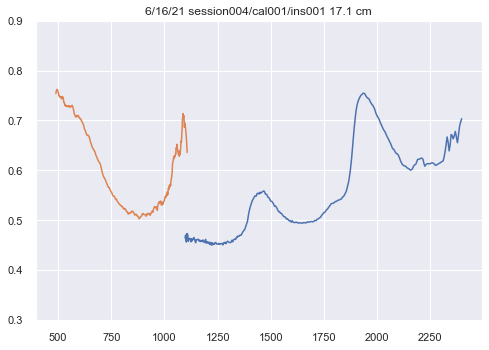

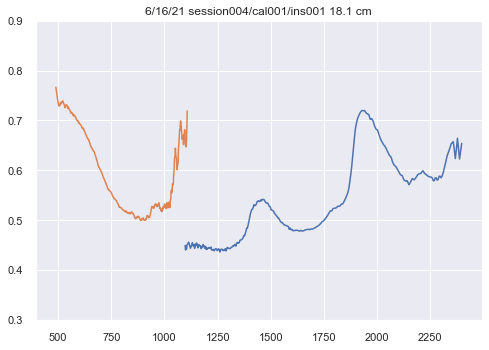

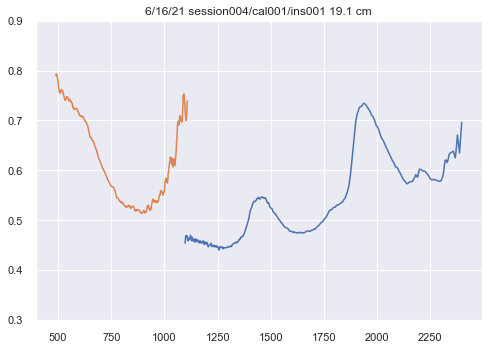

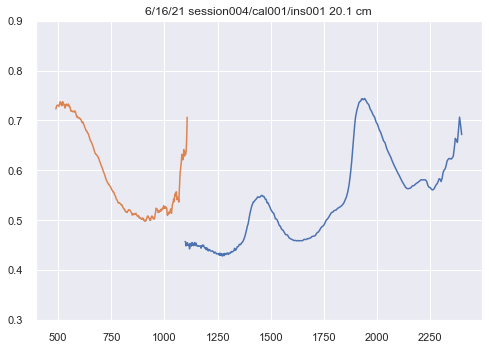

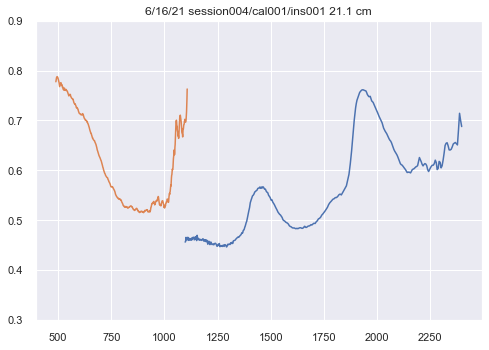

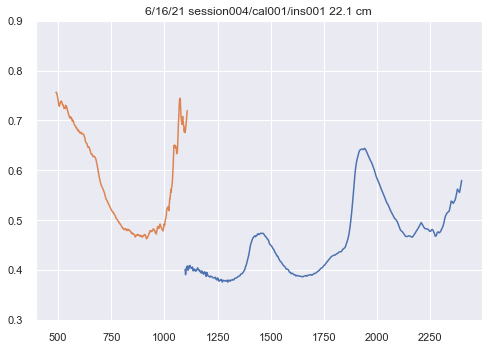

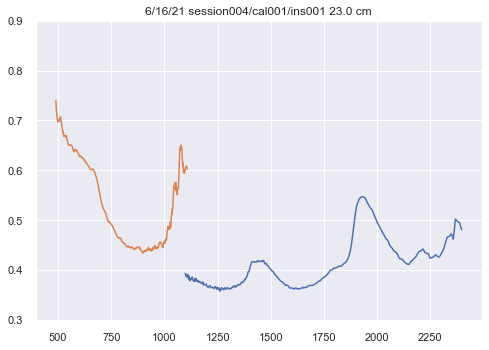

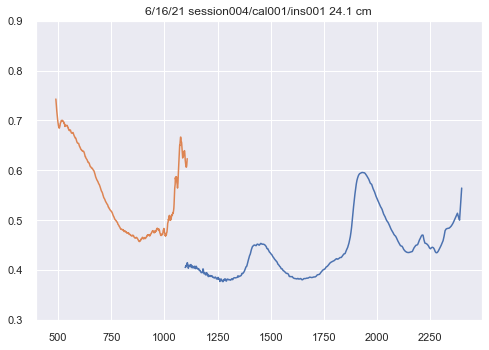

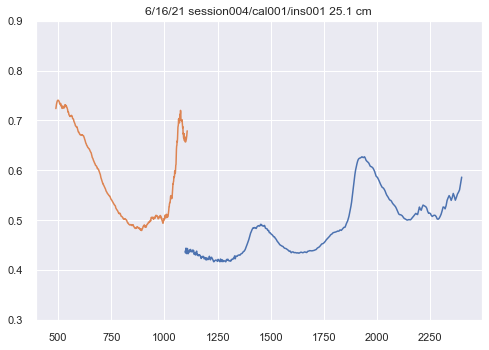

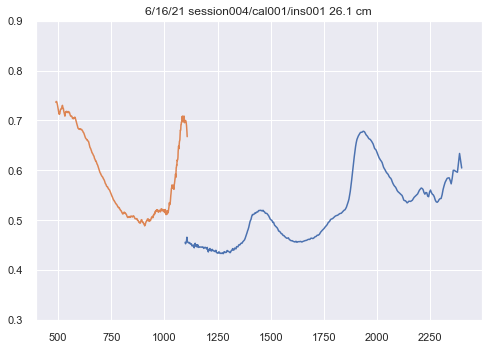

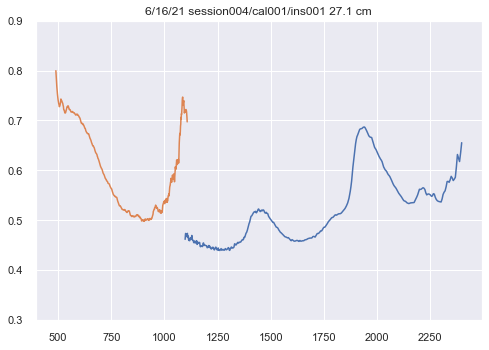

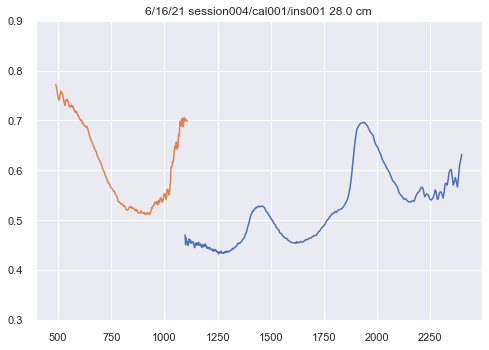

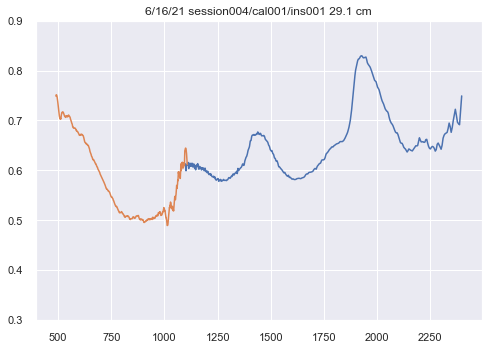

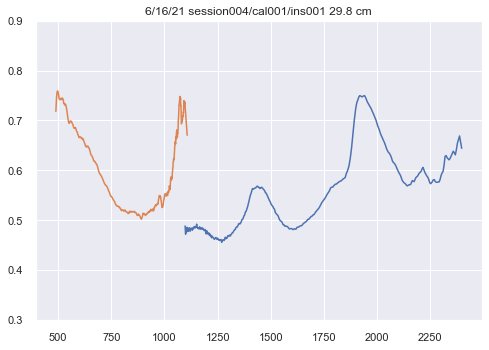

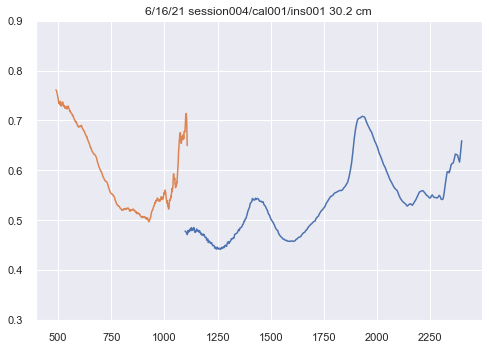

In [13]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name
ftir_min_index = 100
ftir_max_index = 665

depth_min = 0.0
depth_max = 35.0

session = 'session004'
calibration = 'cal001'
insertion = 'ins001'
cal_path = f'{session}/{calibration}'
insertion_path = f'{session}/{calibration}/{insertion}'

ftir_waves = get_visible_wavelength_vector(file, cal_path)
ftir_waves = ftir_waves[ftir_min_index:ftir_max_index]
ftir_absorbances = get_visible_insertion_absorbances(file, insertion_path)
ftir_absorbances = ftir_absorbances[:, ftir_min_index:ftir_max_index]
ftir_depths = get_visible_insertion_spectrum_depths(file, insertion_path)

vis_waves = get_ftir_wavelength_vector(file, cal_path)
vis_absorbances = get_ftir_insertion_absorbances(file, insertion_path)
vis_depths = get_ftir_insertion_spectrum_depths(file, insertion_path)


for i in range(ftir_depths.shape[0]):
    fig, ax = plt.subplots()
    ax.set_title(f'6/16/21 {session}/{calibration}/{insertion} {ftir_depths[i]:0.1f} cm')
    ax.set_ylim(0.3, 0.9)    
    ax.plot(ftir_waves, ftir_absorbances[i, :])
    ax.plot(vis_waves, savgol_filter(vis_absorbances[i, :], 21, 3))
    plt.show()
    plt.close()

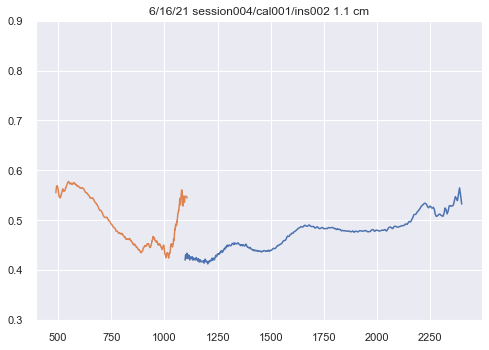

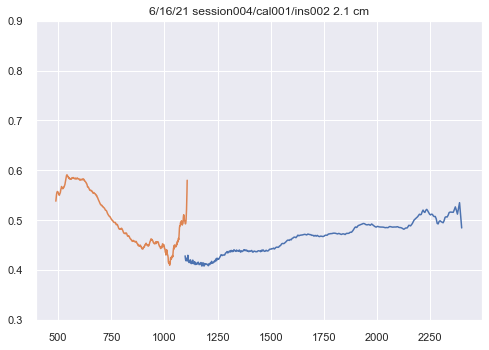

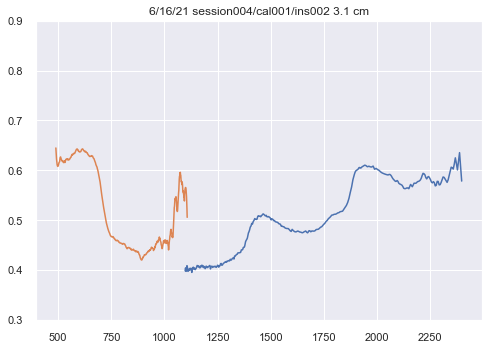

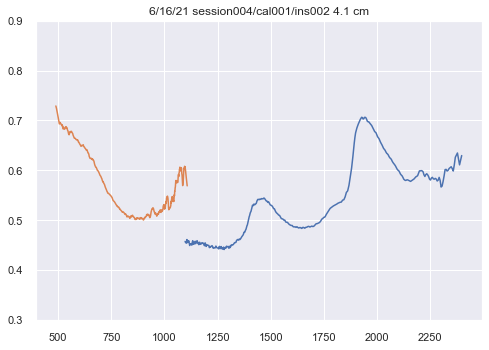

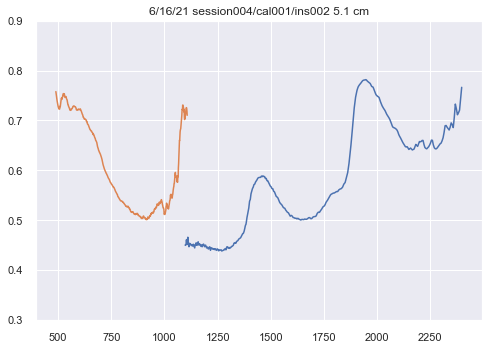

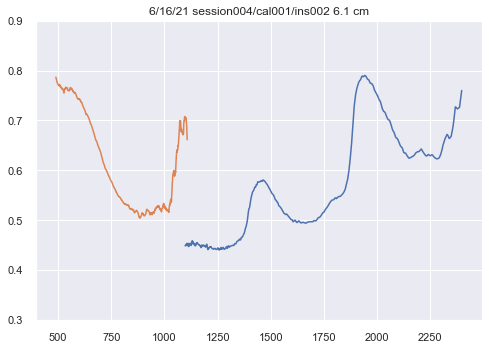

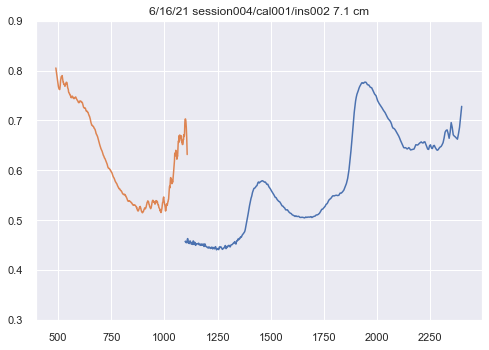

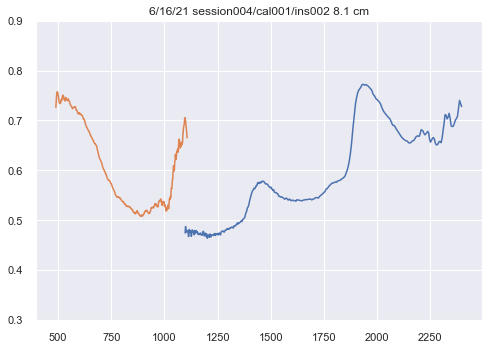

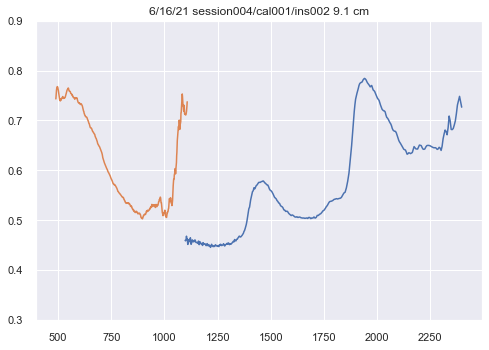

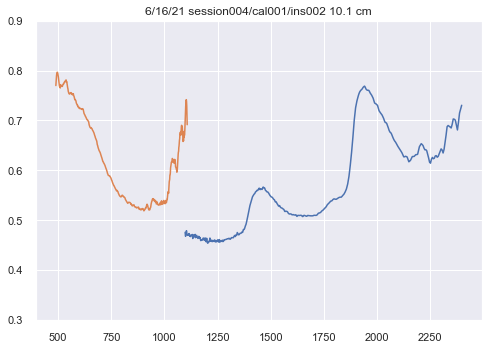

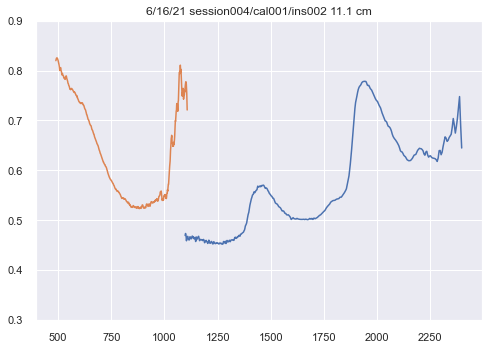

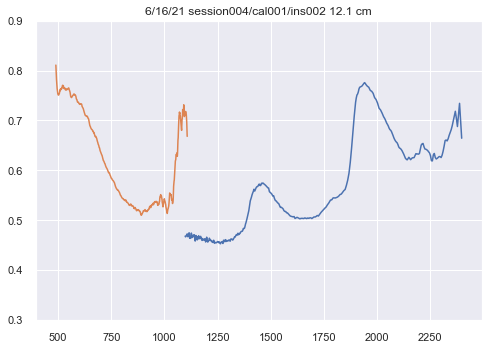

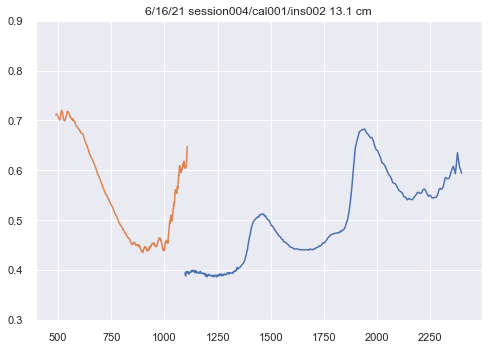

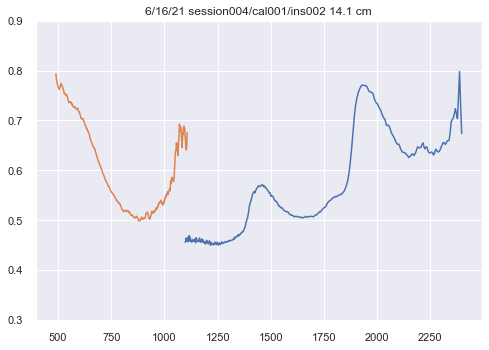

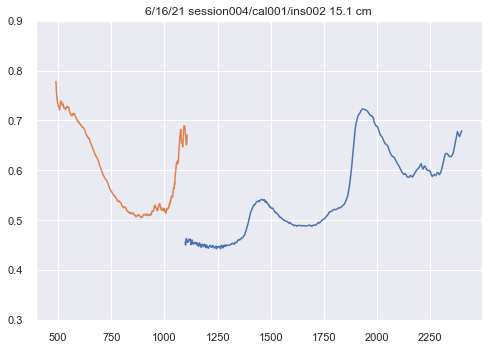

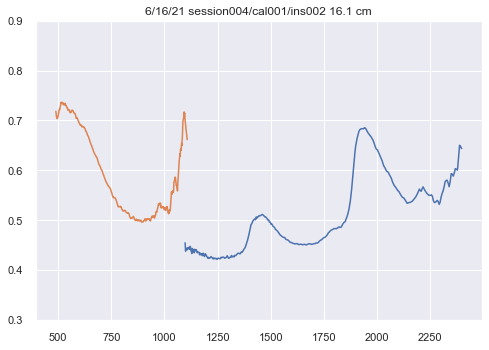

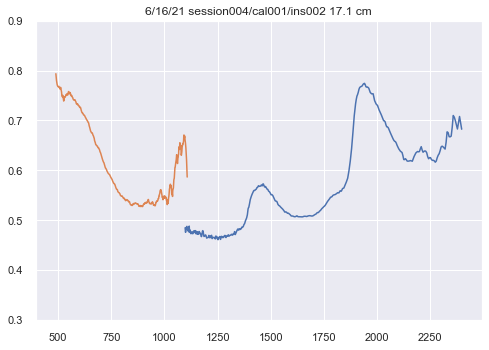

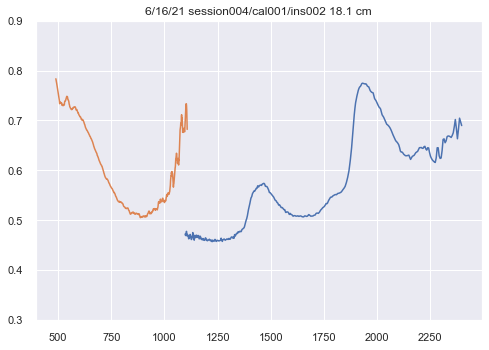

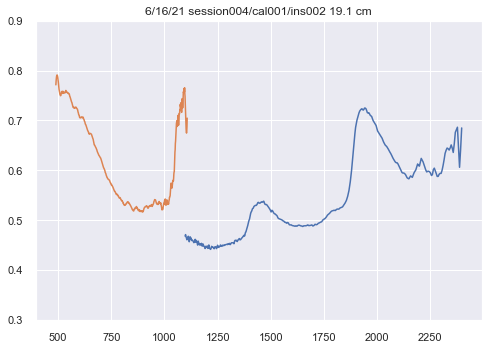

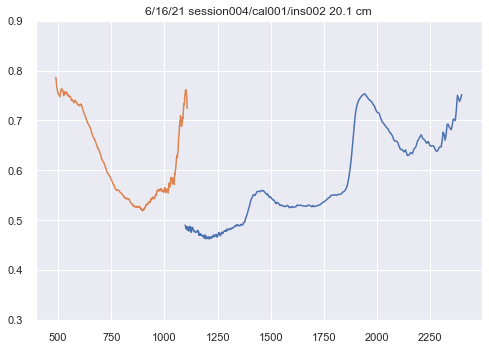

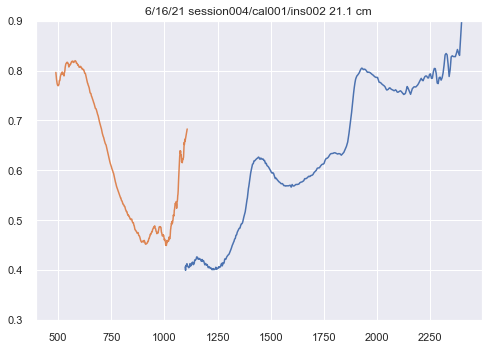

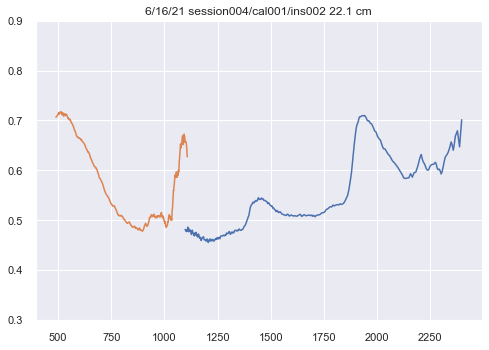

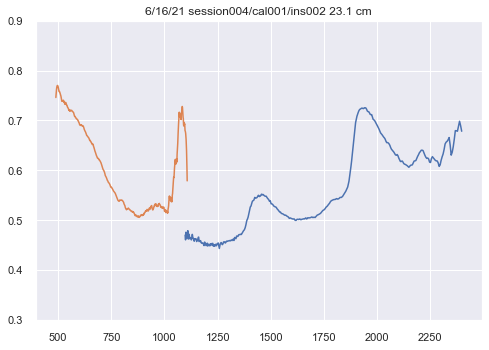

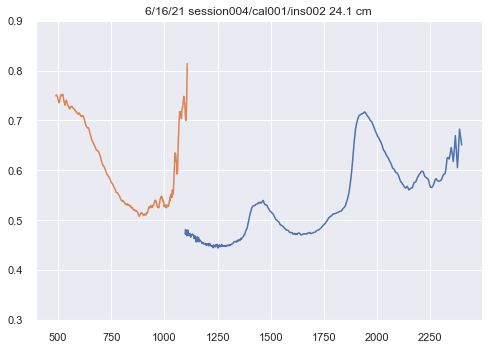

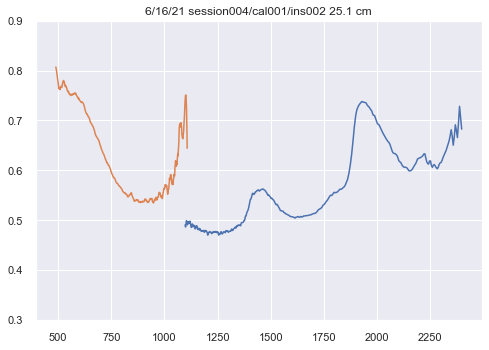

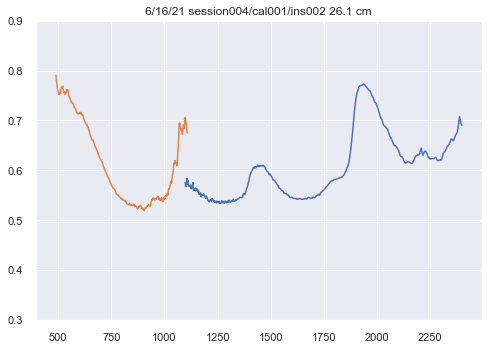

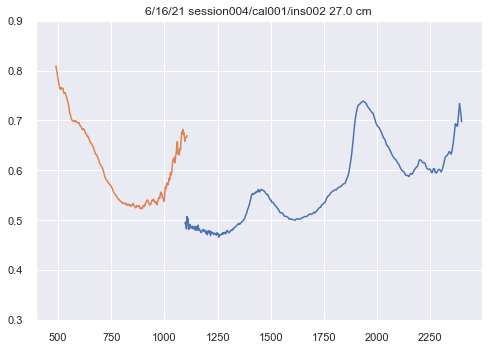

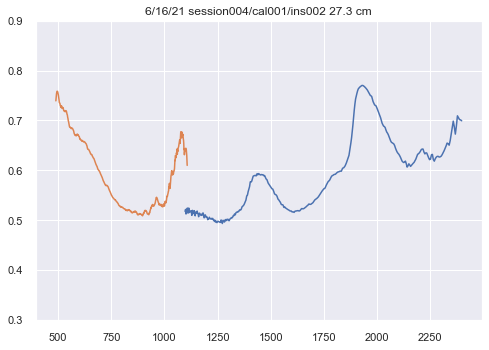

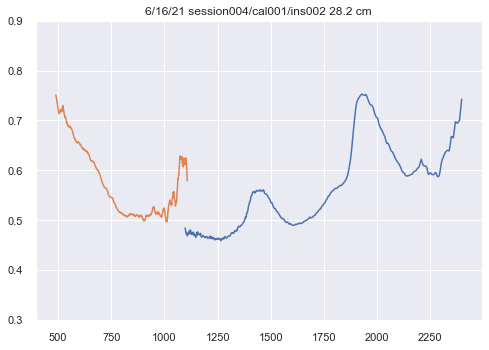

In [14]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = insertions_list_df.iat[0, 0]
file = path_name + file_name
ftir_min_index = 100
ftir_max_index = 665

depth_min = 0.0
depth_max = 35.0

session = 'session004'
calibration = 'cal001'
insertion = 'ins002'
cal_path = f'{session}/{calibration}'
insertion_path = f'{session}/{calibration}/{insertion}'

ftir_waves = get_visible_wavelength_vector(file, cal_path)
ftir_waves = ftir_waves[ftir_min_index:ftir_max_index]
ftir_absorbances = get_visible_insertion_absorbances(file, insertion_path)
ftir_absorbances = ftir_absorbances[:, ftir_min_index:ftir_max_index]
ftir_depths = get_visible_insertion_spectrum_depths(file, insertion_path)

vis_waves = get_ftir_wavelength_vector(file, cal_path)
vis_absorbances = get_ftir_insertion_absorbances(file, insertion_path)
vis_depths = get_ftir_insertion_spectrum_depths(file, insertion_path)


for i in range(ftir_depths.shape[0]):
    fig, ax = plt.subplots()
    ax.set_title(f'6/16/21 {session}/{calibration}/{insertion} {ftir_depths[i]:0.1f} cm')
    ax.set_ylim(0.3, 0.9)    
    ax.plot(ftir_waves, ftir_absorbances[i, :])
    ax.plot(vis_waves, savgol_filter(vis_absorbances[i, :], 21, 3))
    plt.show()
    plt.close()